## Autores

- Carlos Eduardo Fontaneli
RA 769949 

- Ivan Duarte Calvo 
Ra 790739

### Bibliotecas necessárias

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from scipy.stats import mode
from sklearn.ensemble import VotingClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### Leitura dos dados e descrição do conjunto

O conjunto trata de uma coletânea de dados relativos a pesquisas de satisfação de passageiros de uma companhia área. O objetivo é classificar, dado um conjunto de atributos relativos a um voo, se um passageiro ficará satisfeito ou não ao final da viagem. <br>
O dataset conta com dezenas de atributos sendo eles relativos a duração do voo, qualiade de serviços oferecidos durante a viagem, questões de infraestrutura do avião e aeroporto, entre outros.<br>
Ademais, o dataset possui uma divisão própria de arquivos que separam os dados entre treino e teste.<br>

Dataset: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

In [139]:
dataset = pd.read_csv('train.csv')
dataset_test = pd.read_csv('test.csv')
dataset.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Análise exploratória inicial dos dados

De início realizou-se uma análise exploratória dos dados em busca de enteder sua distribuição, comportamento e balanceamento.

In [140]:
dataset.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [141]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [142]:
labels = list(dataset.columns[2:])
labels.remove('Flight Distance')
labels.remove('Arrival Delay in Minutes')
labels.remove('Departure Delay in Minutes')

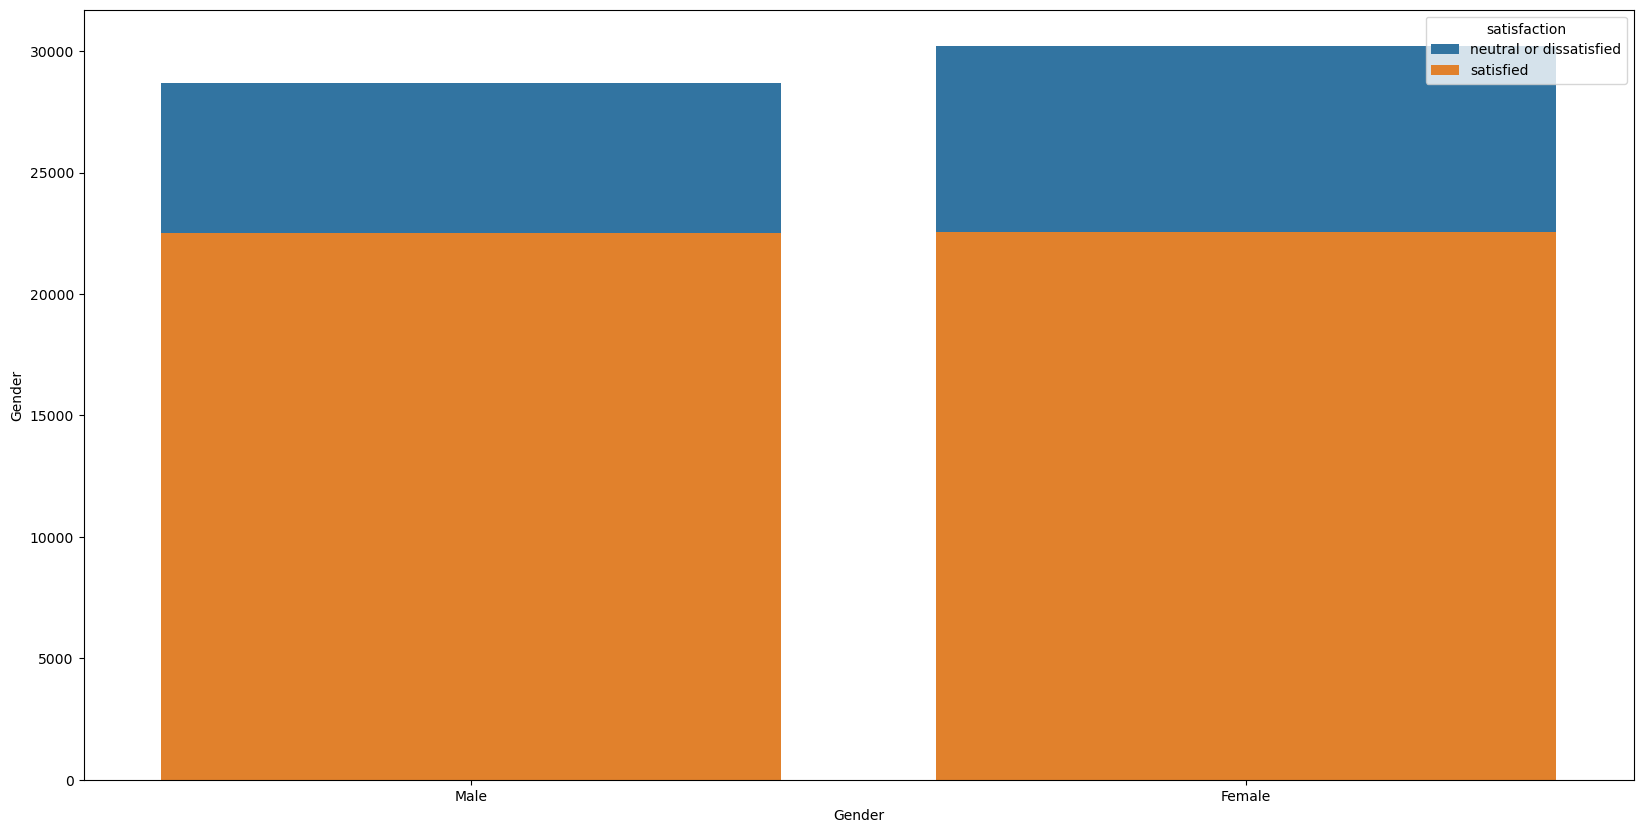

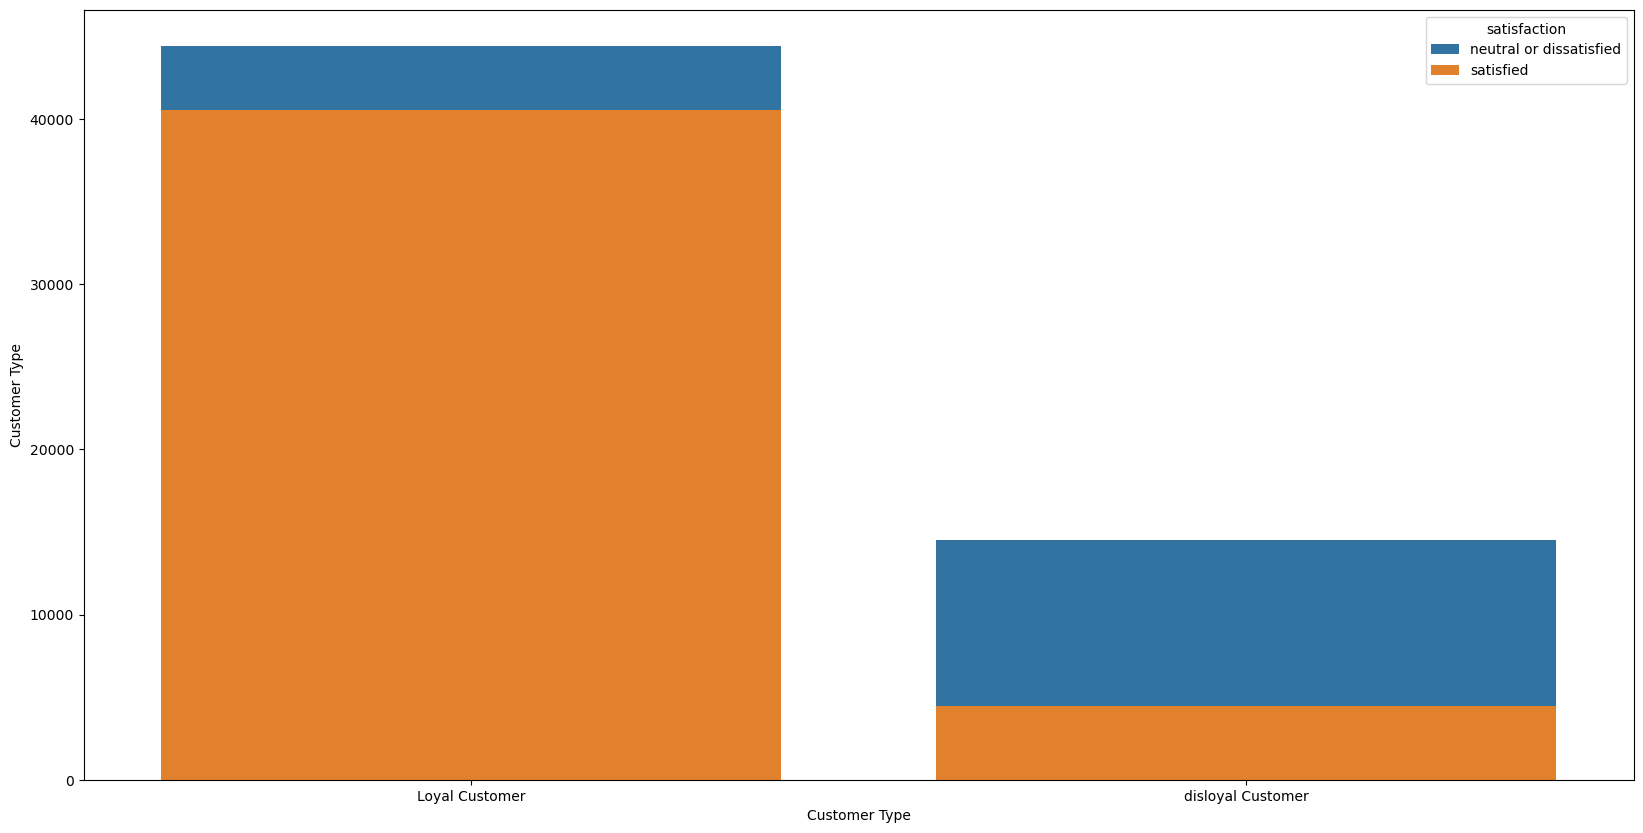

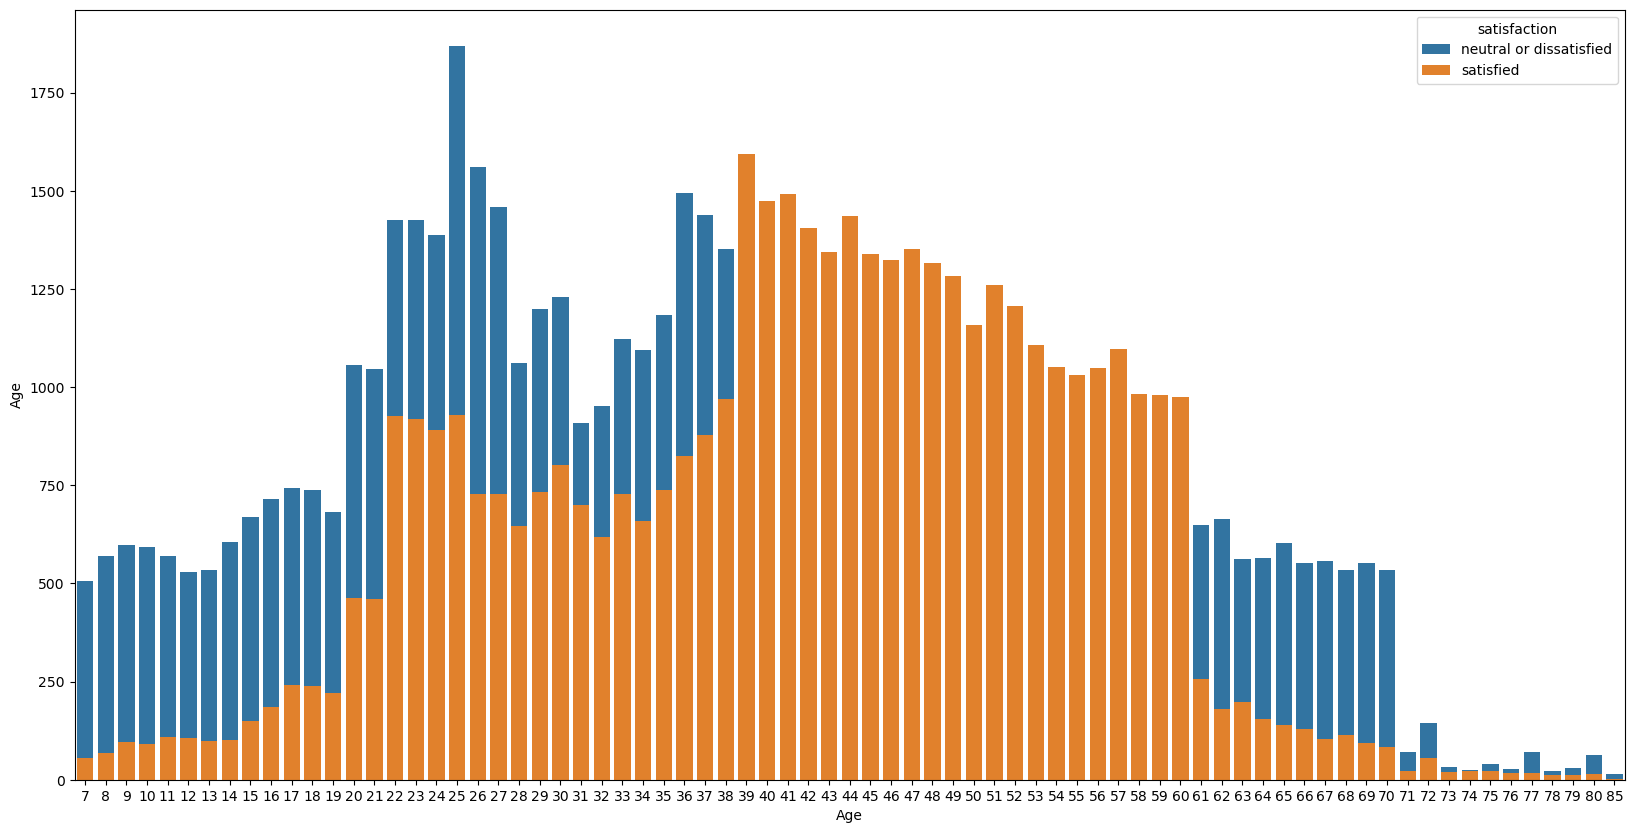

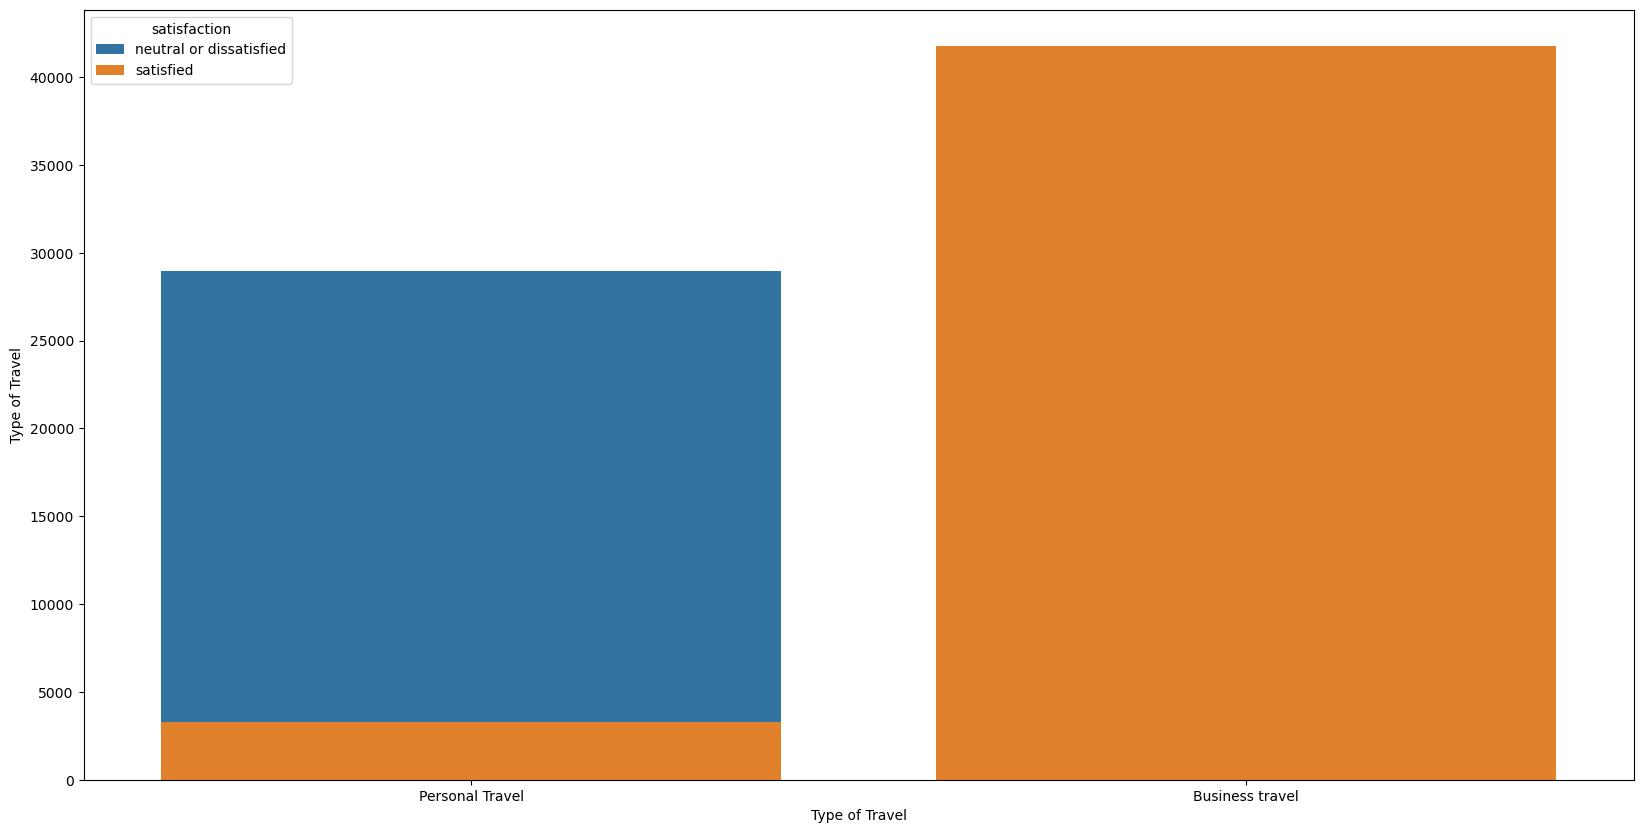

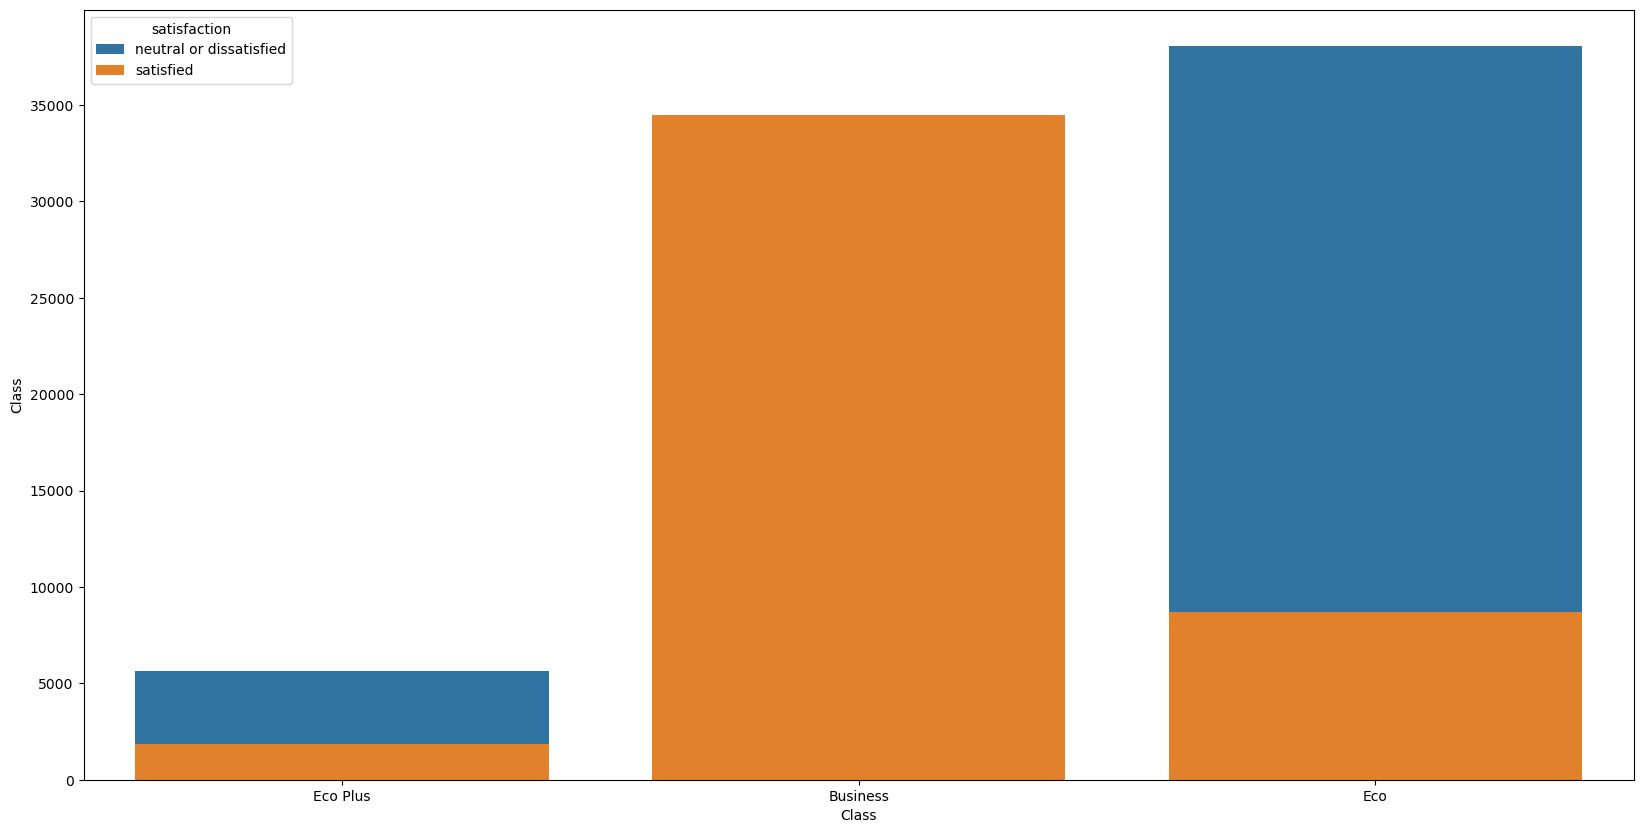

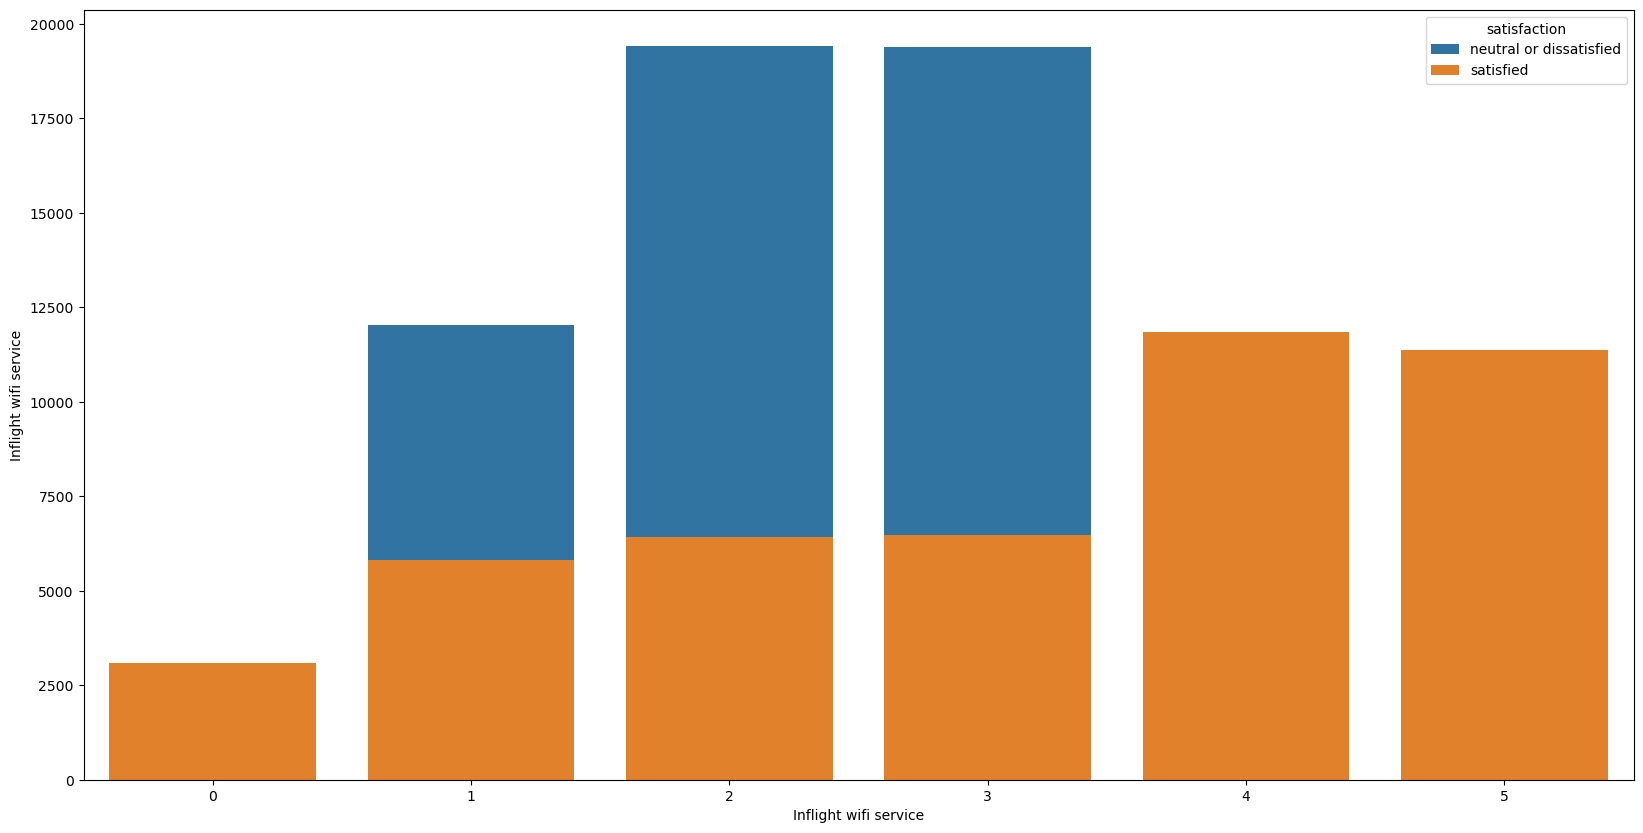

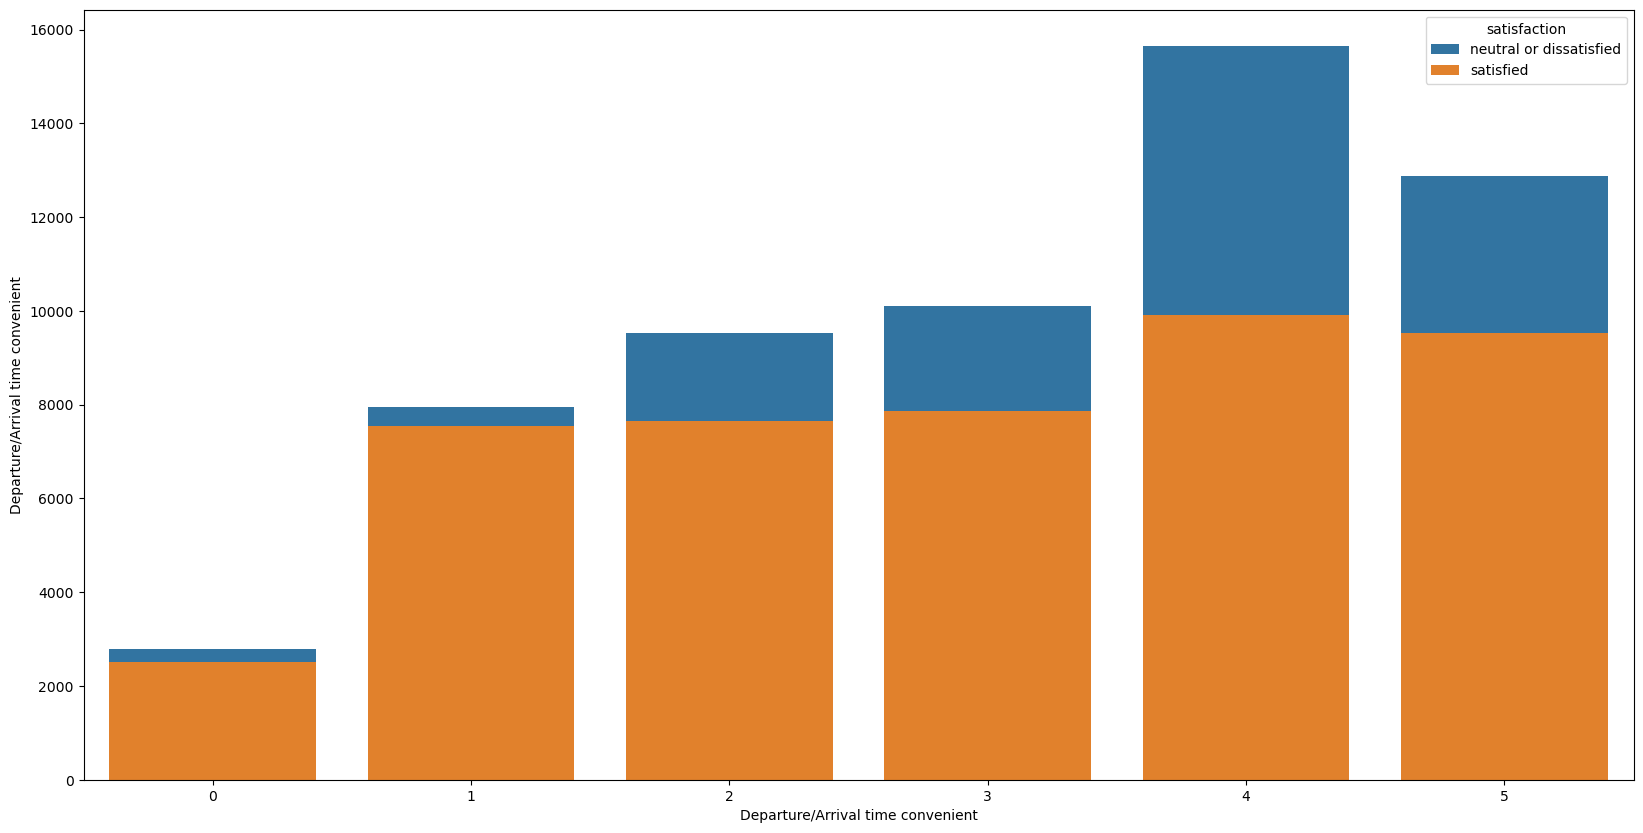

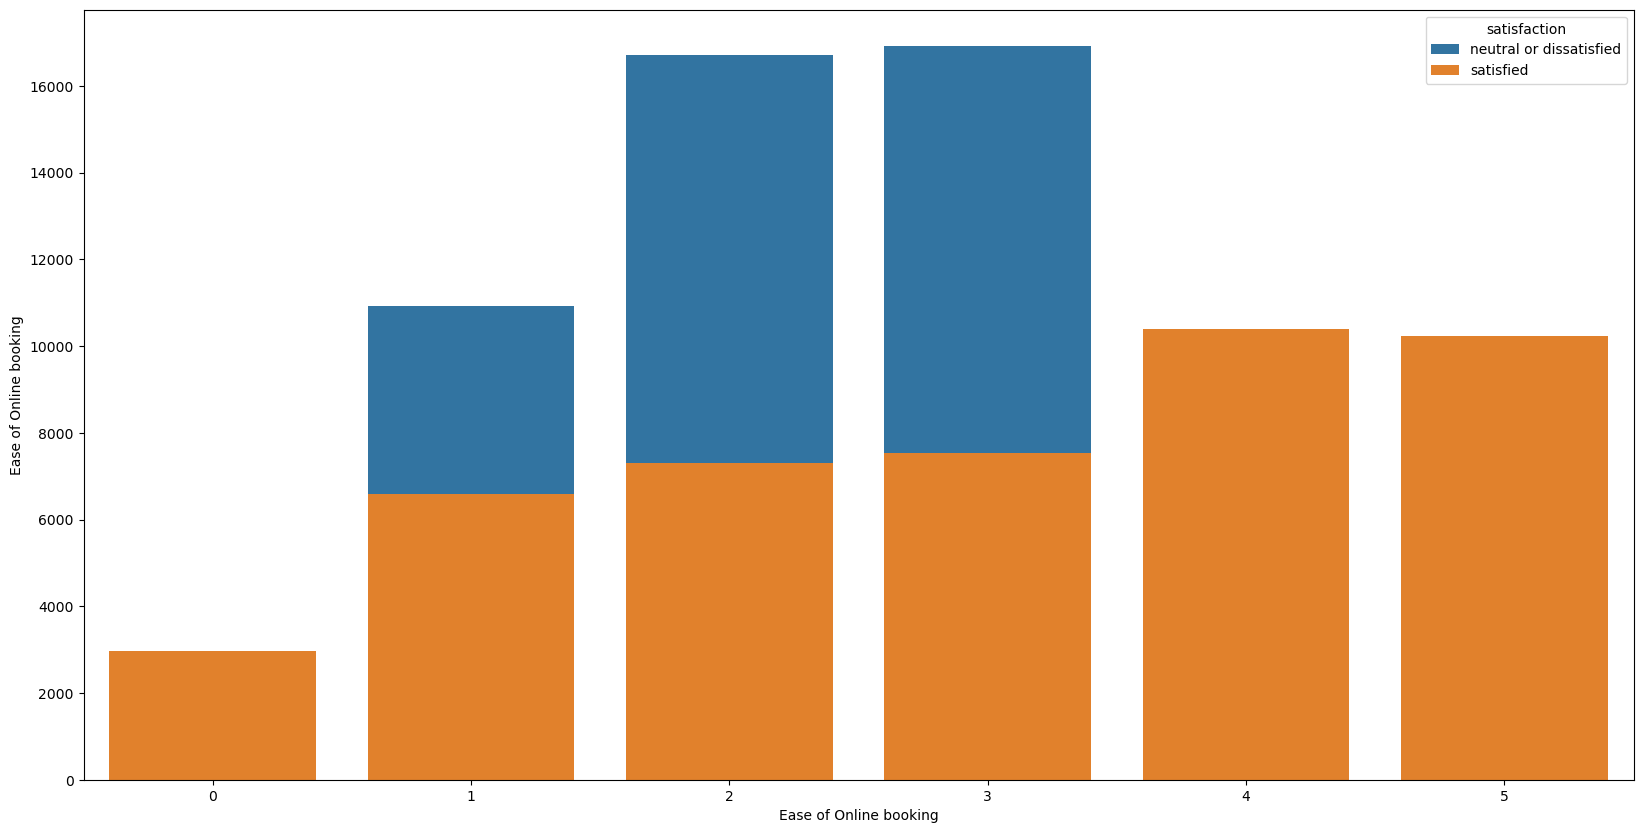

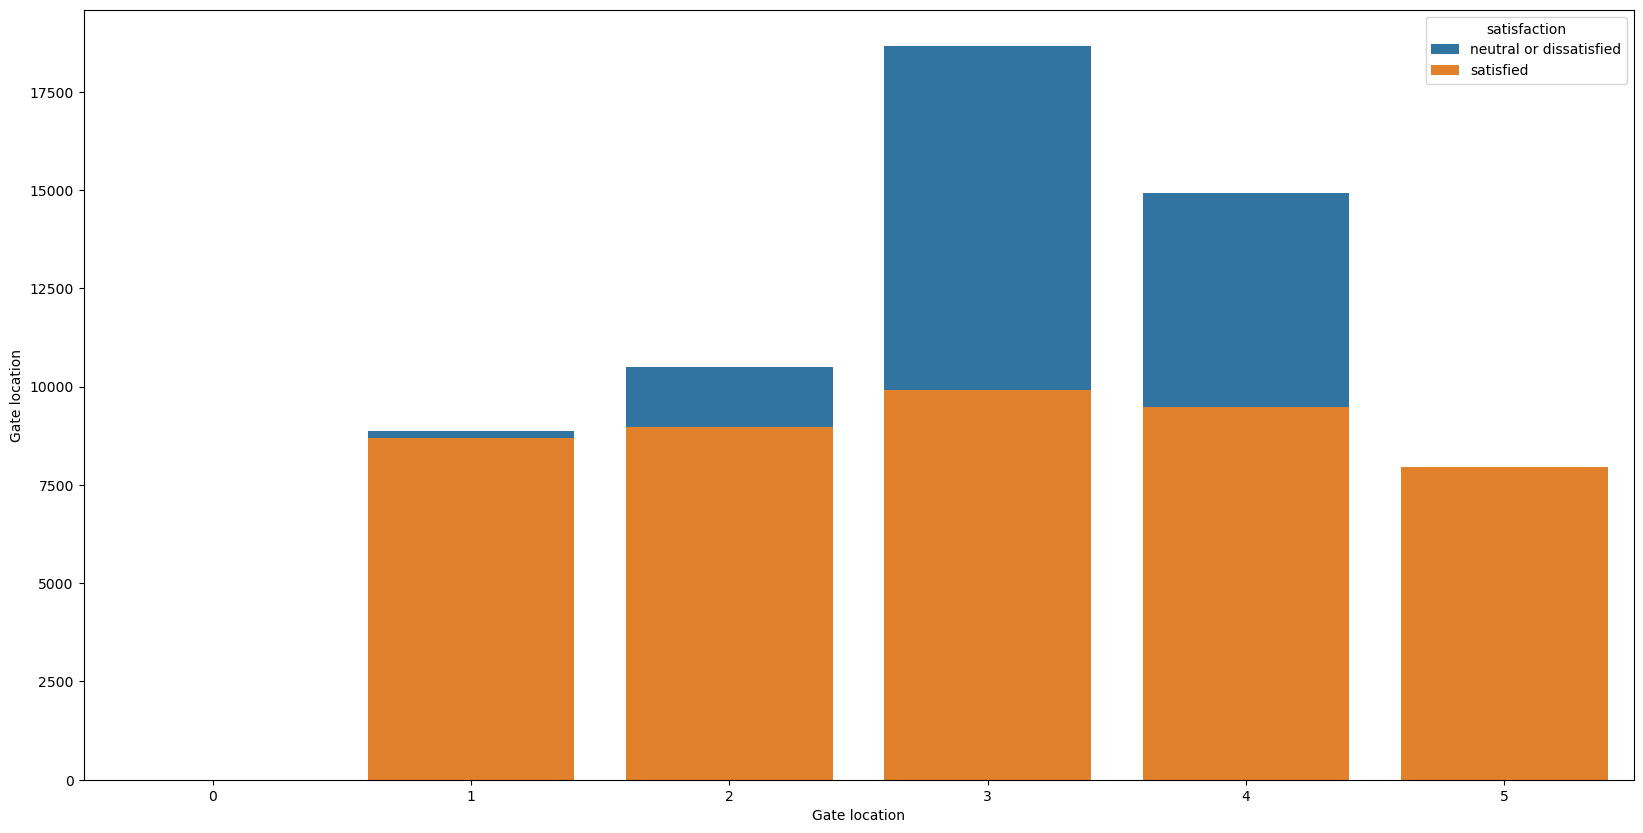

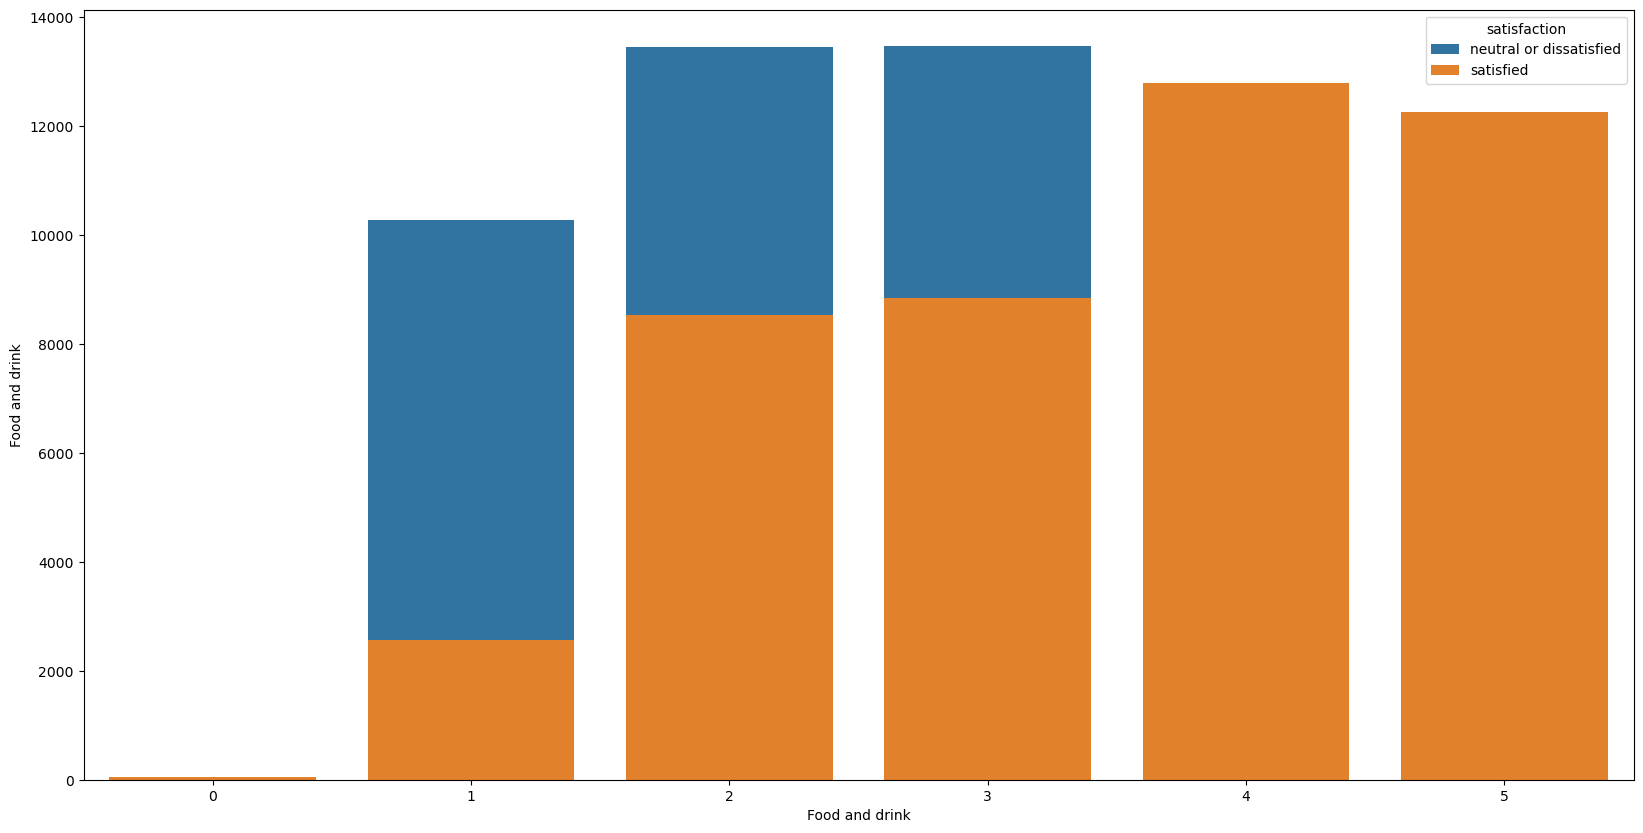

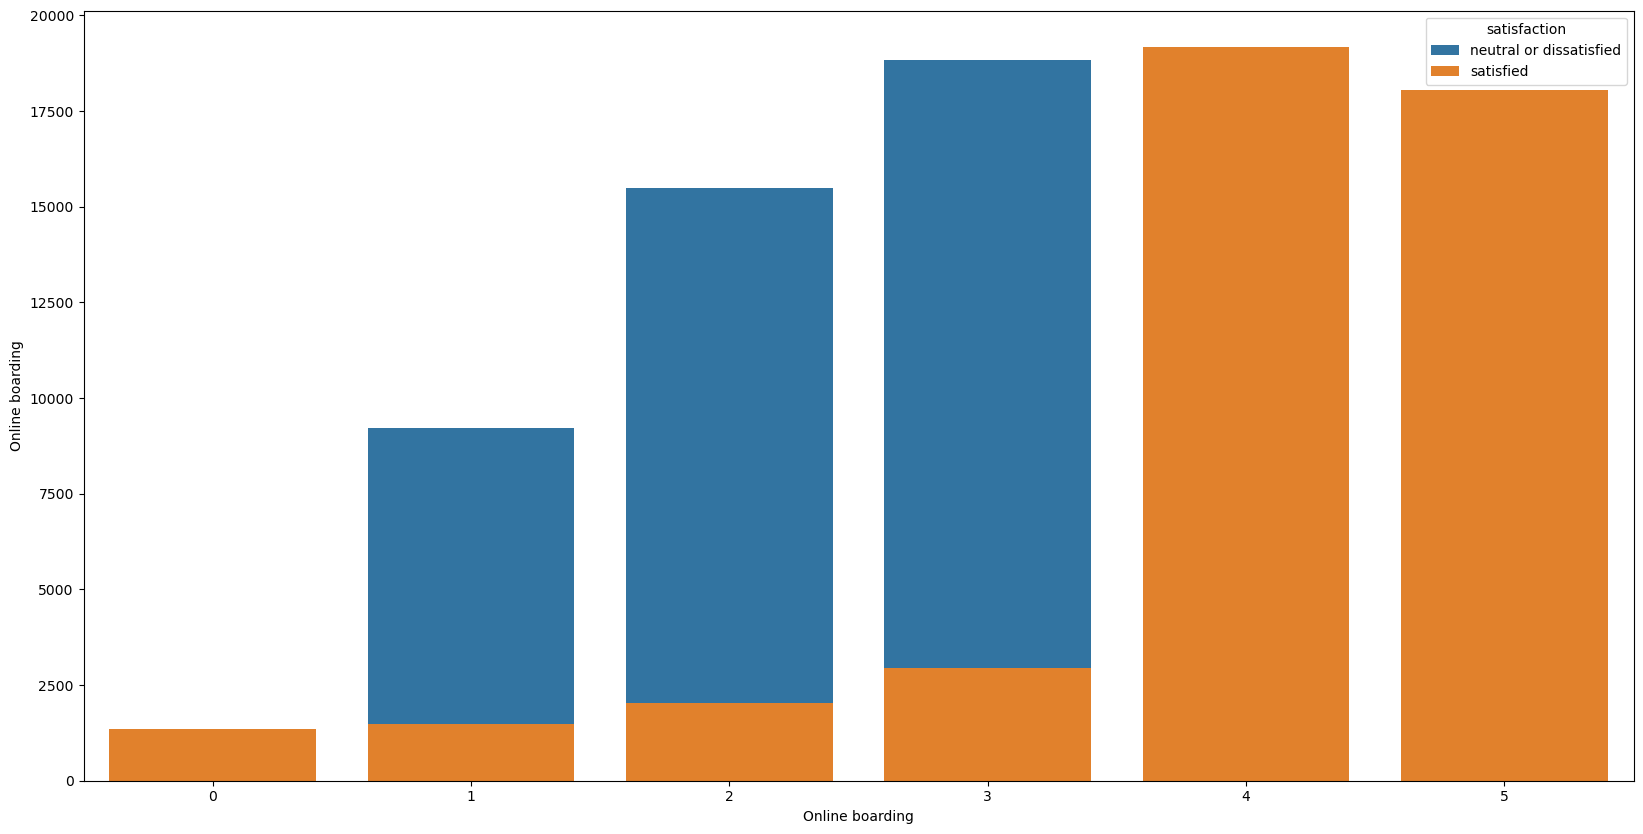

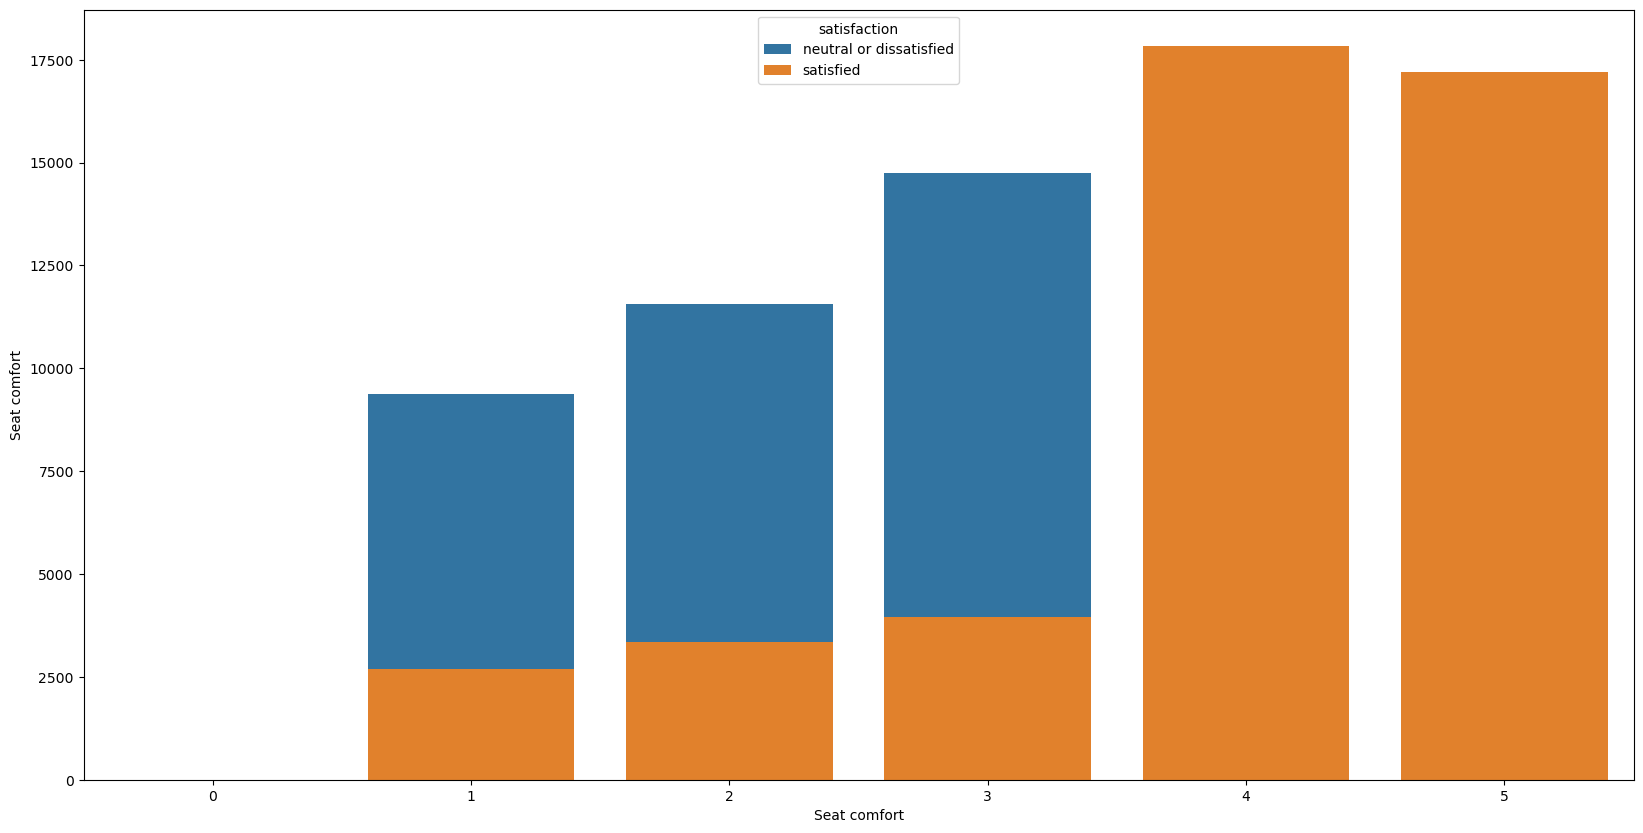

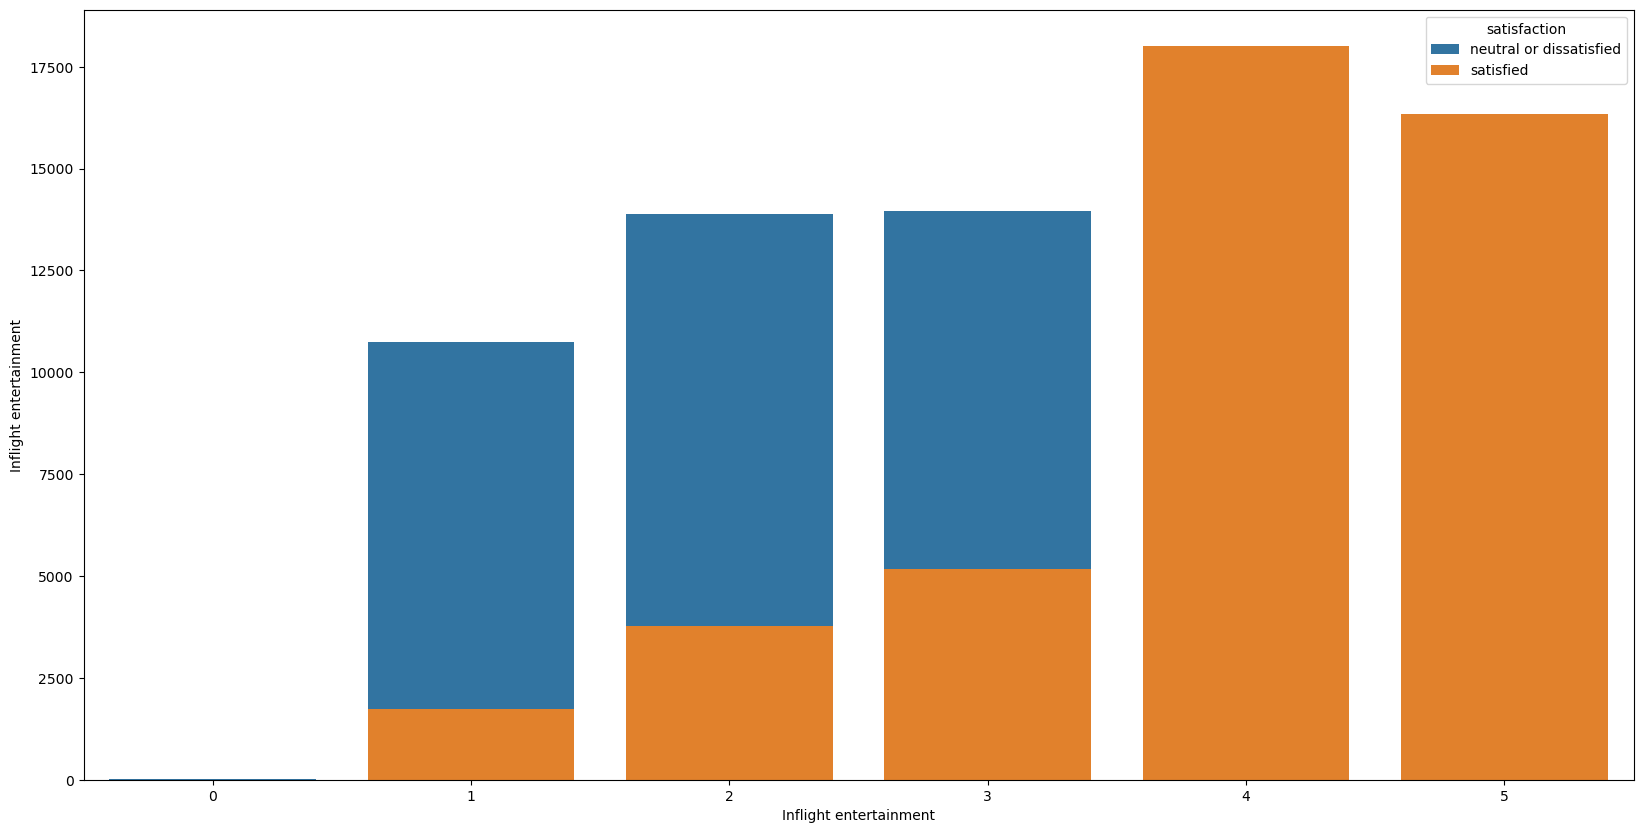

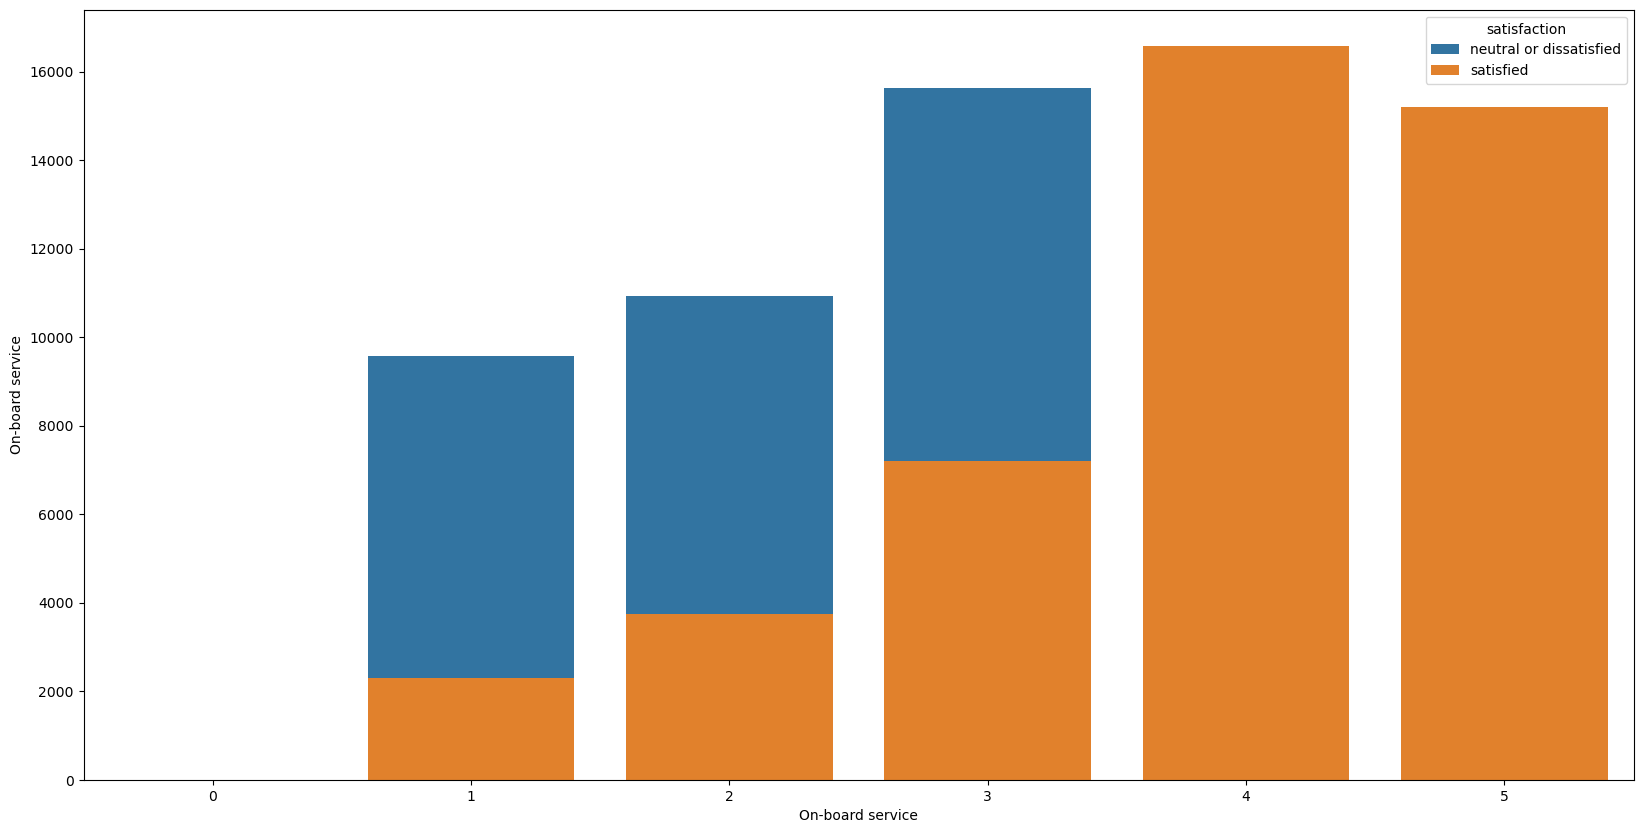

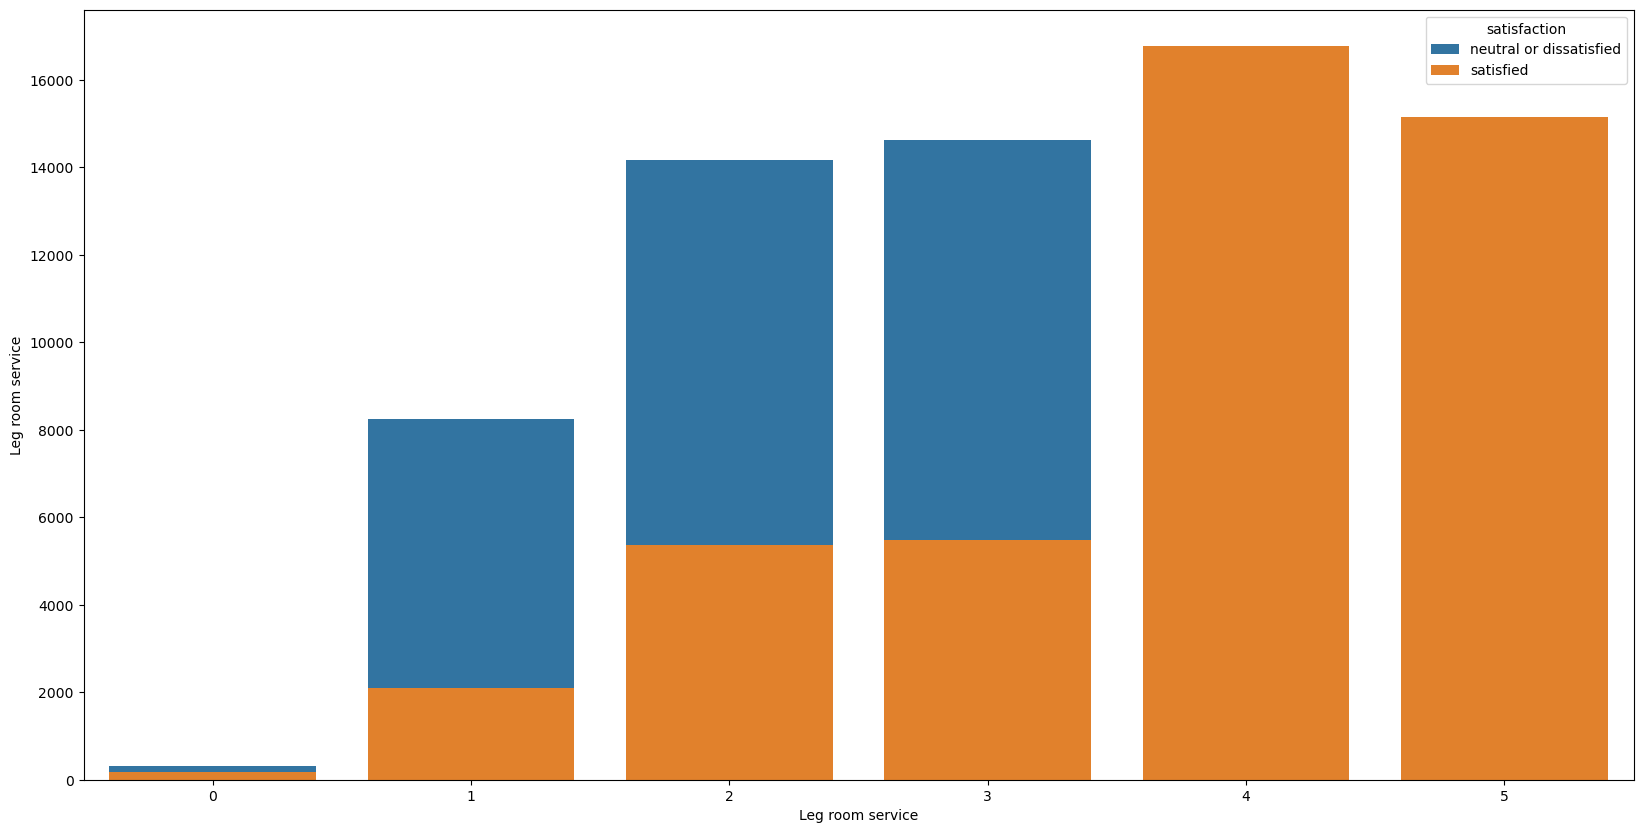

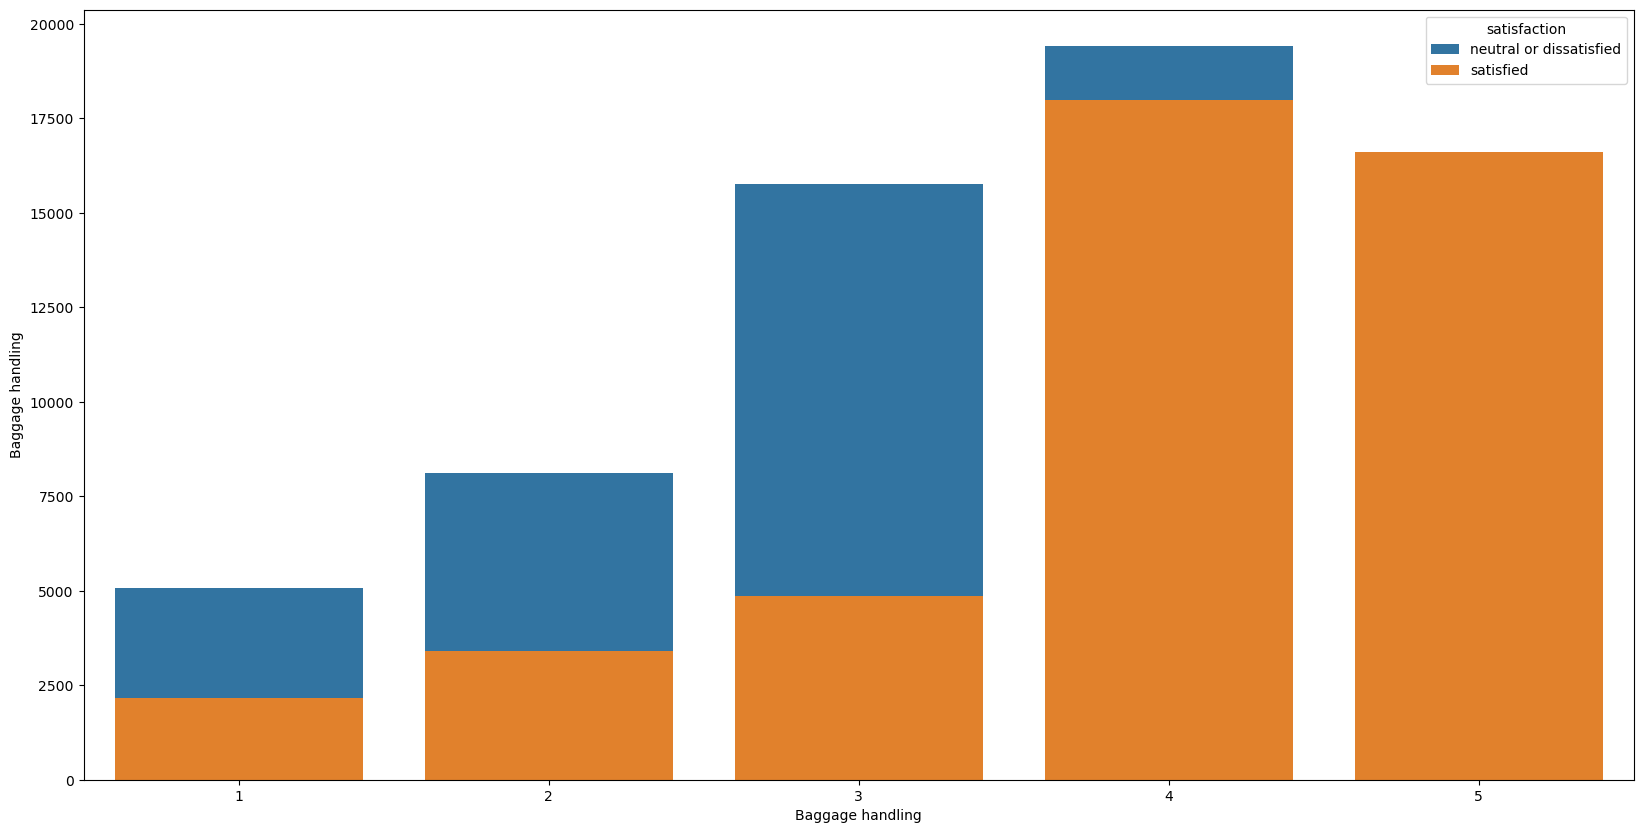

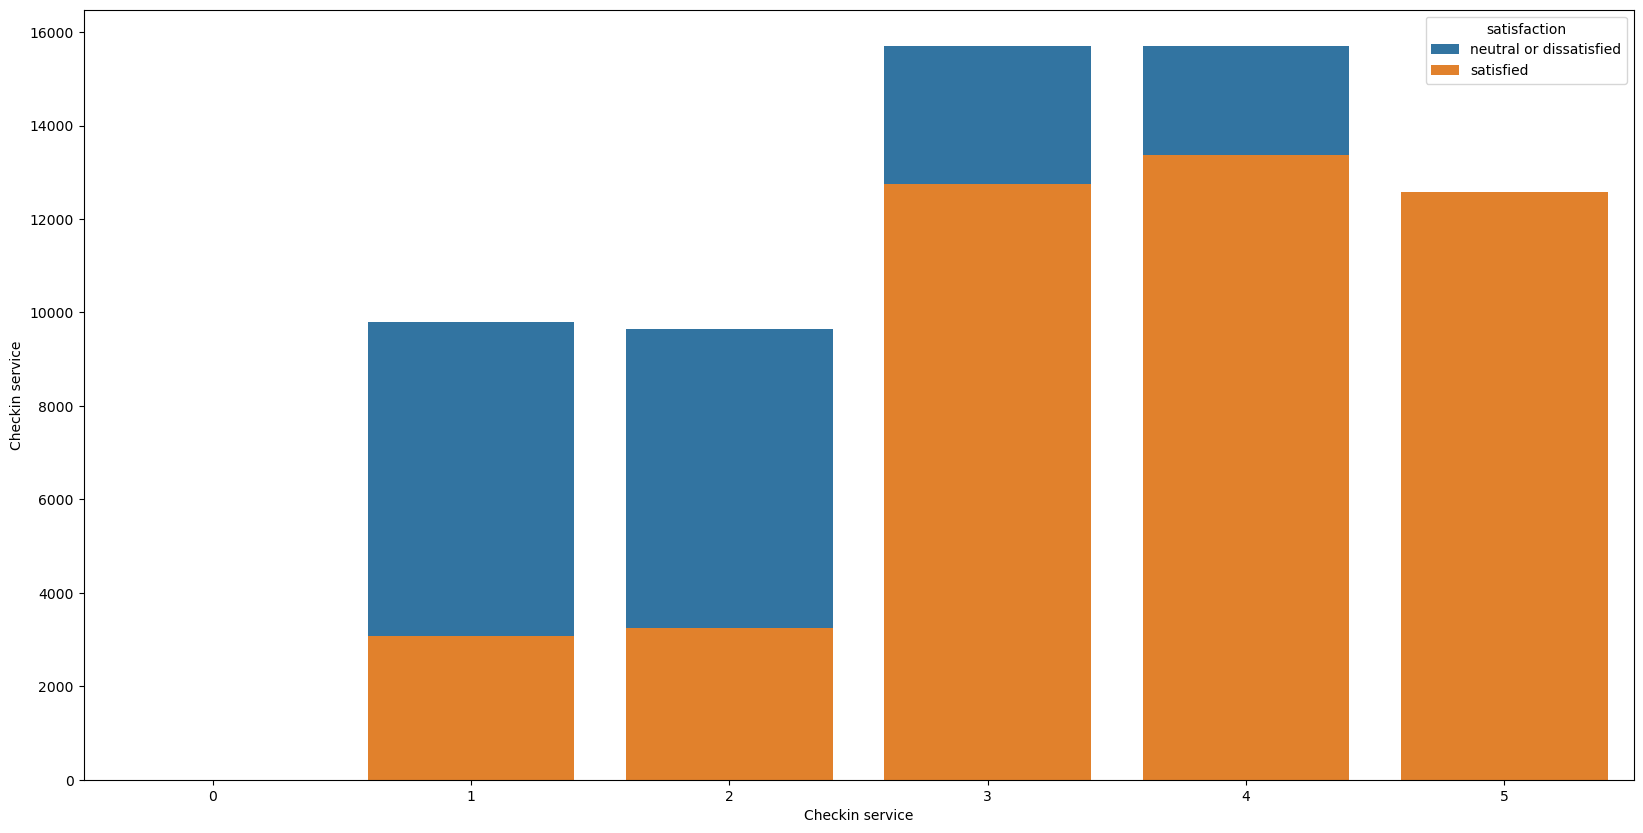

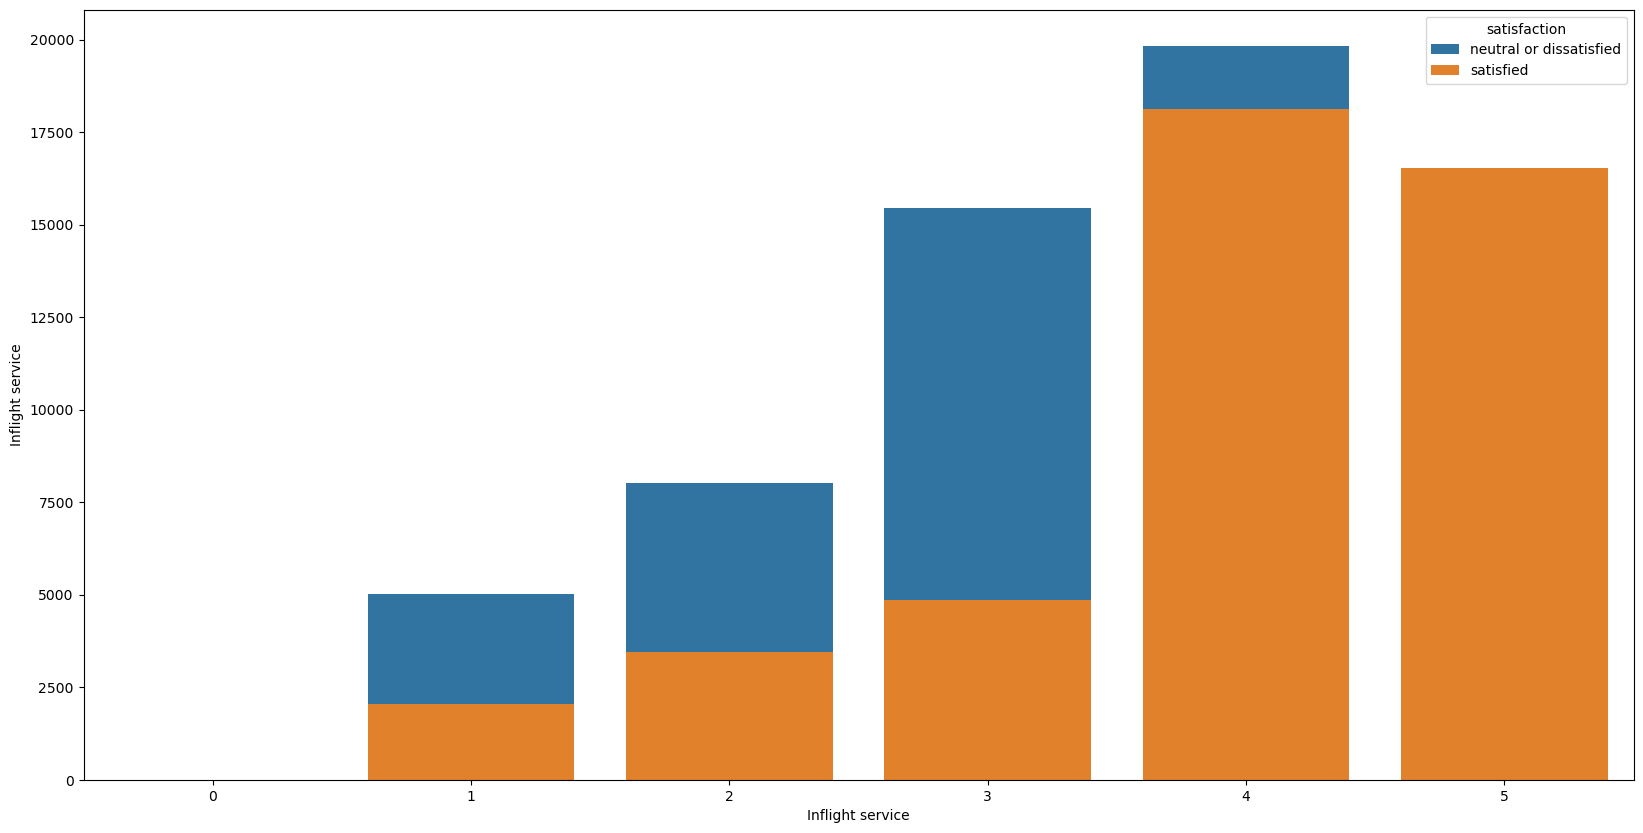

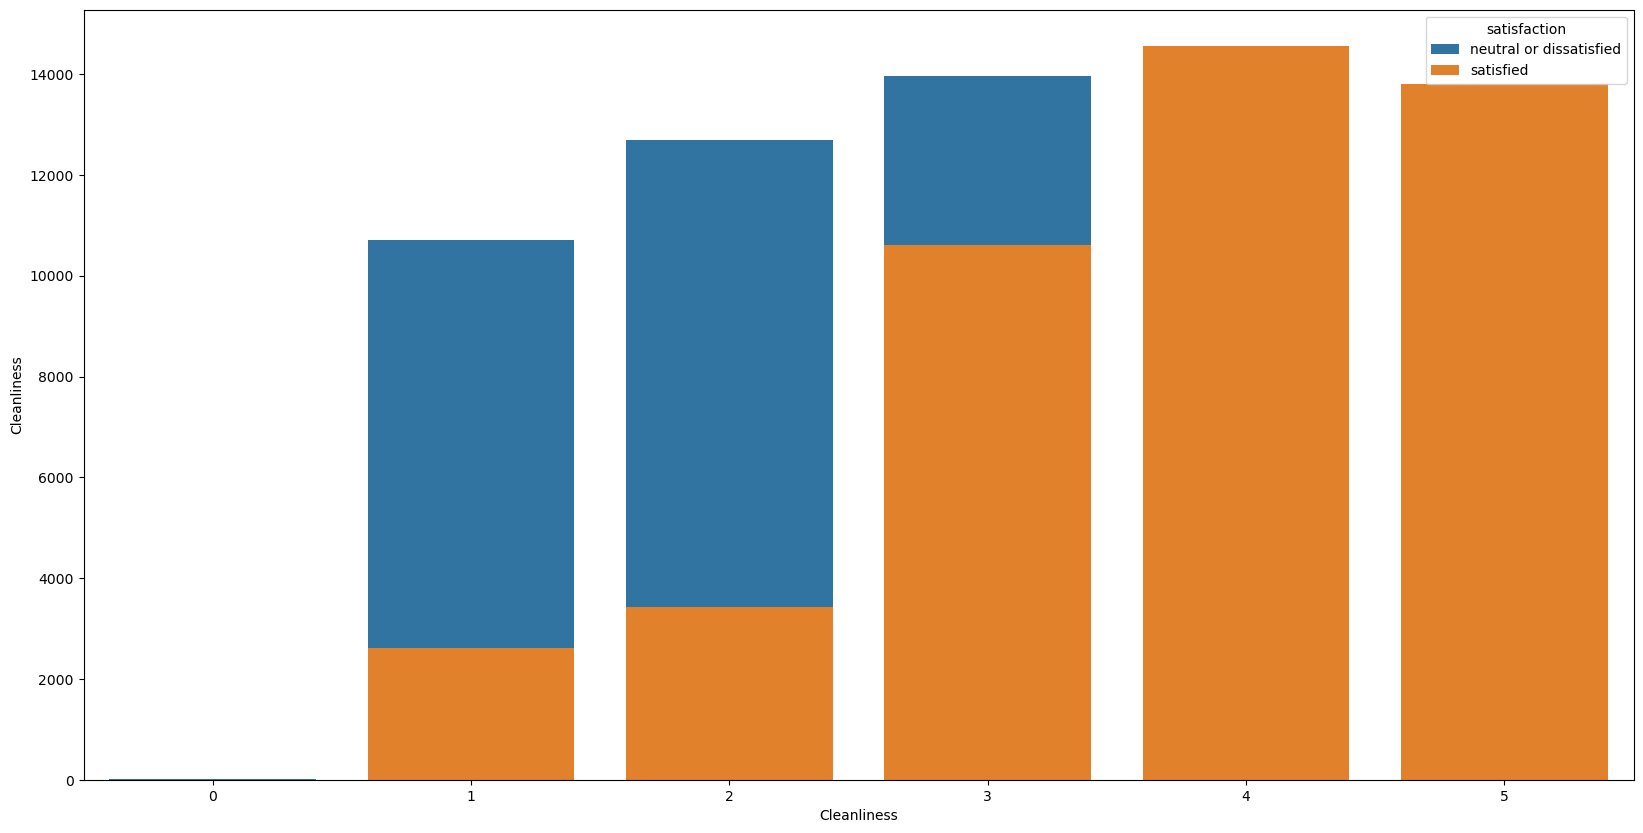

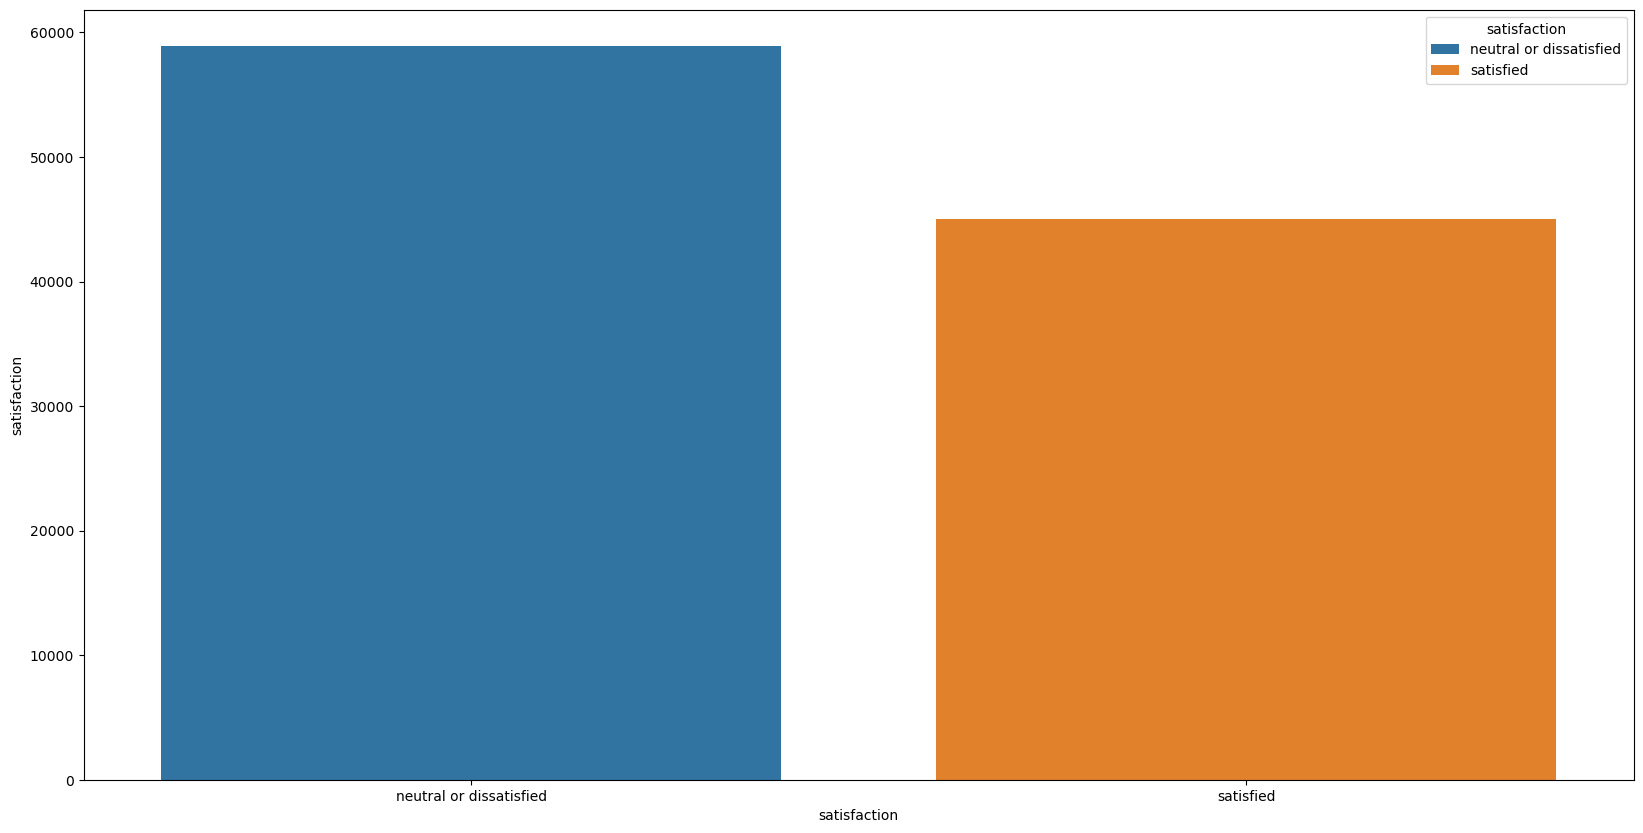

In [143]:
# Plotagem dos dados
for label in labels:
    plt.figure(figsize=[20,10])
    sns.countplot(x=label, data=dataset, hue=dataset['satisfaction'], dodge=False)
    _ = plt.ylabel(label)
    _ = plt.show()

### Observações

- Foi possível notar que clientes na faixa etátia entre 40 e 59 possuem um tendência a ter mais satisfação durante os voos;

- Todos os clientes que voaram por razões de negócios ficaram satisfeitos;

- Boa qualidade nos serviços de wifi e comidas e bebidas está fortemente relacionada a satisfação dos clientes;

- Voos com assentos de melhor qualidade possuíram sempre clientes satisfeitos;

- De forma geral, quanto melhor os serviços ofertados durante o voo, maior tende a ser a satisfação do cliente; 

- O atraso na partida acarreta em atraso na chegada;

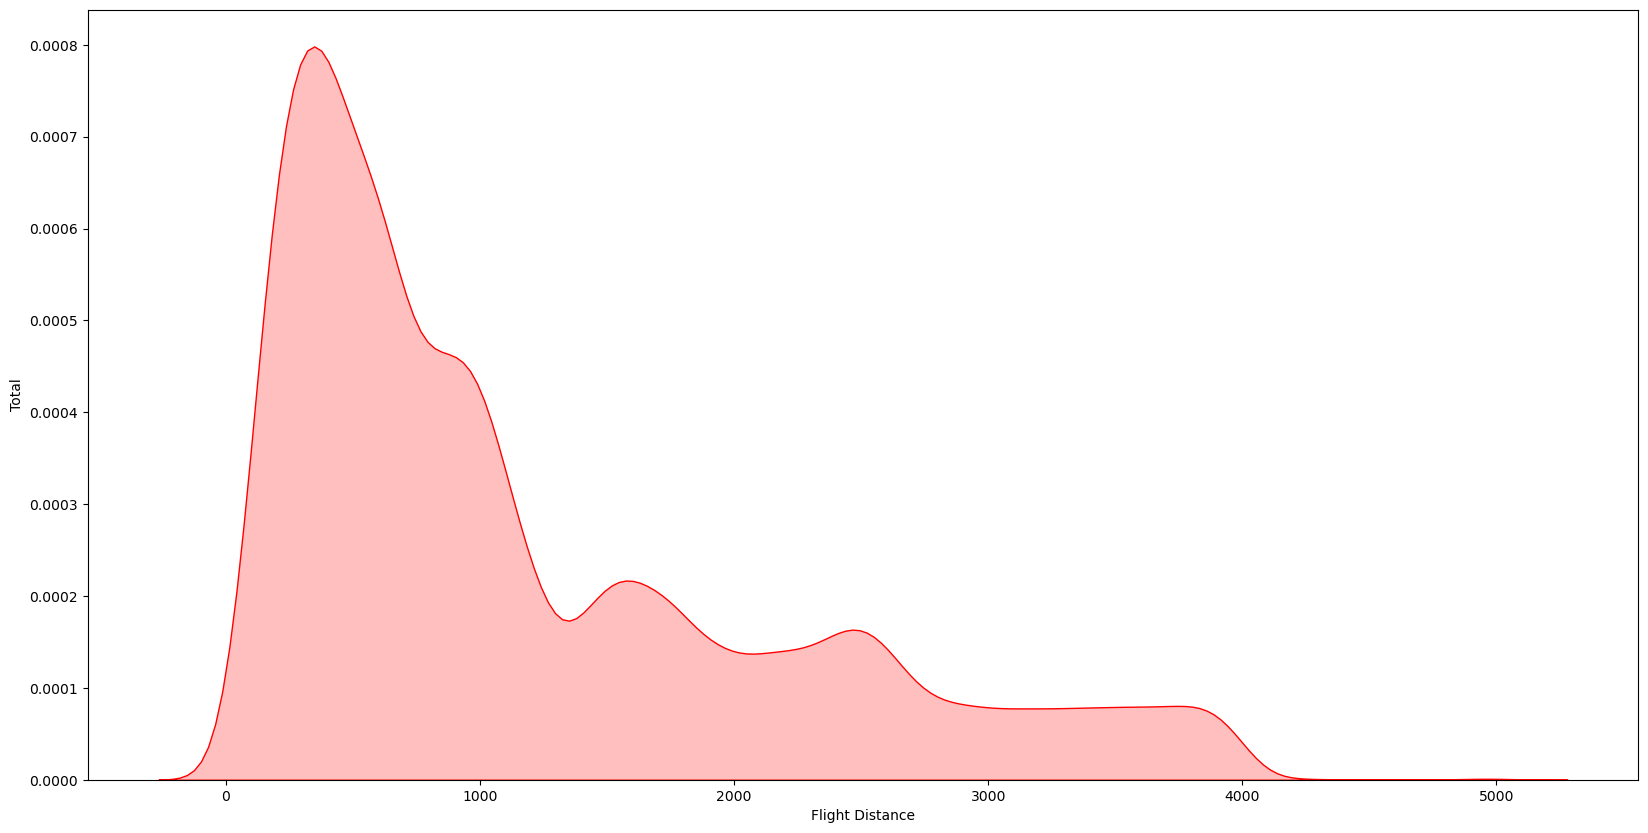

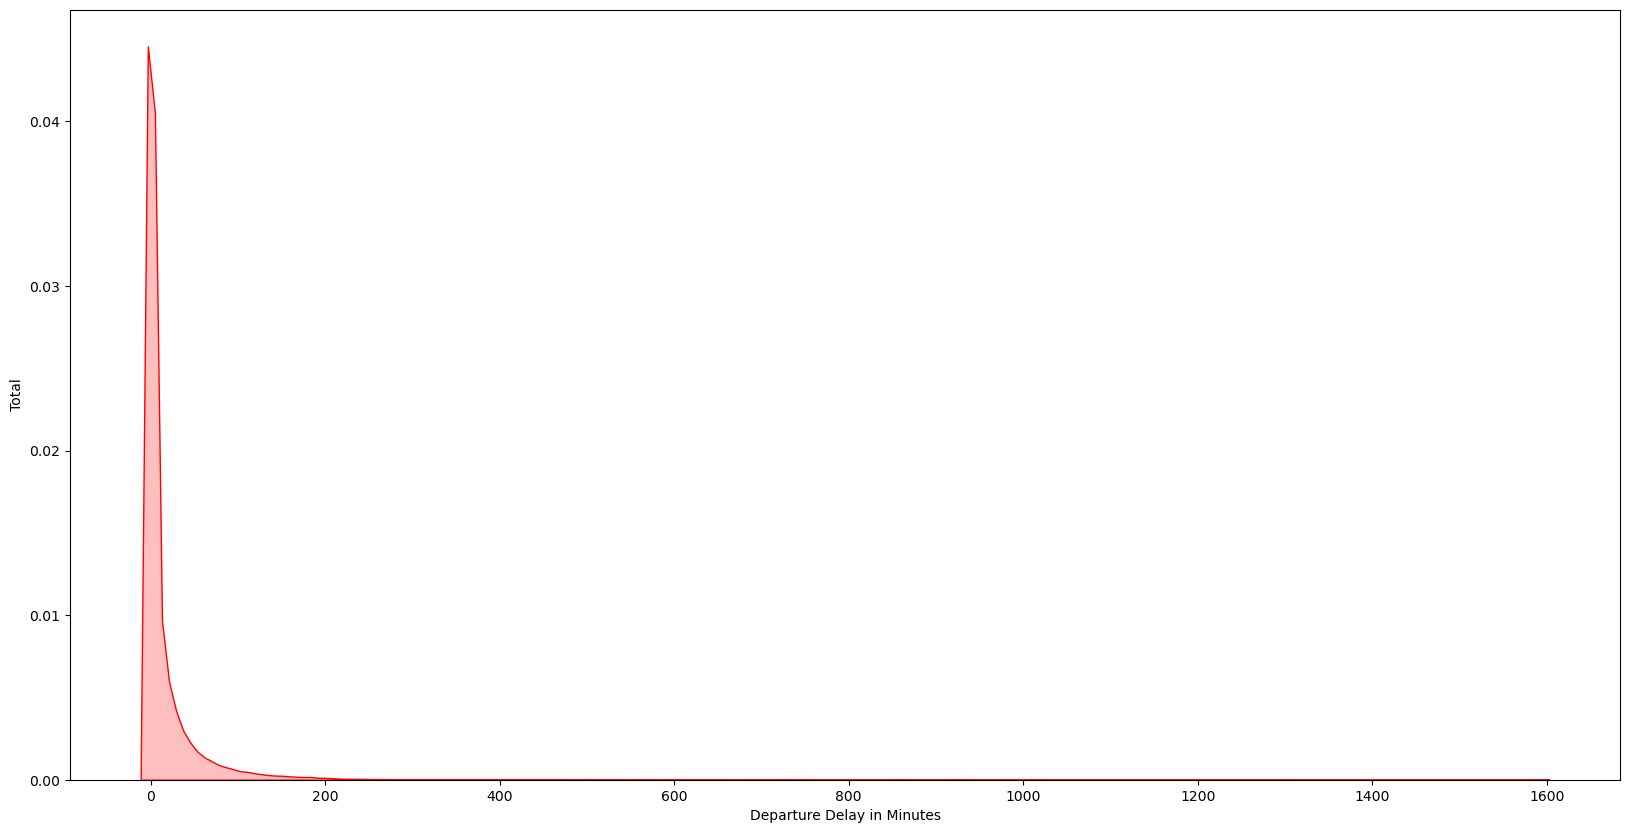

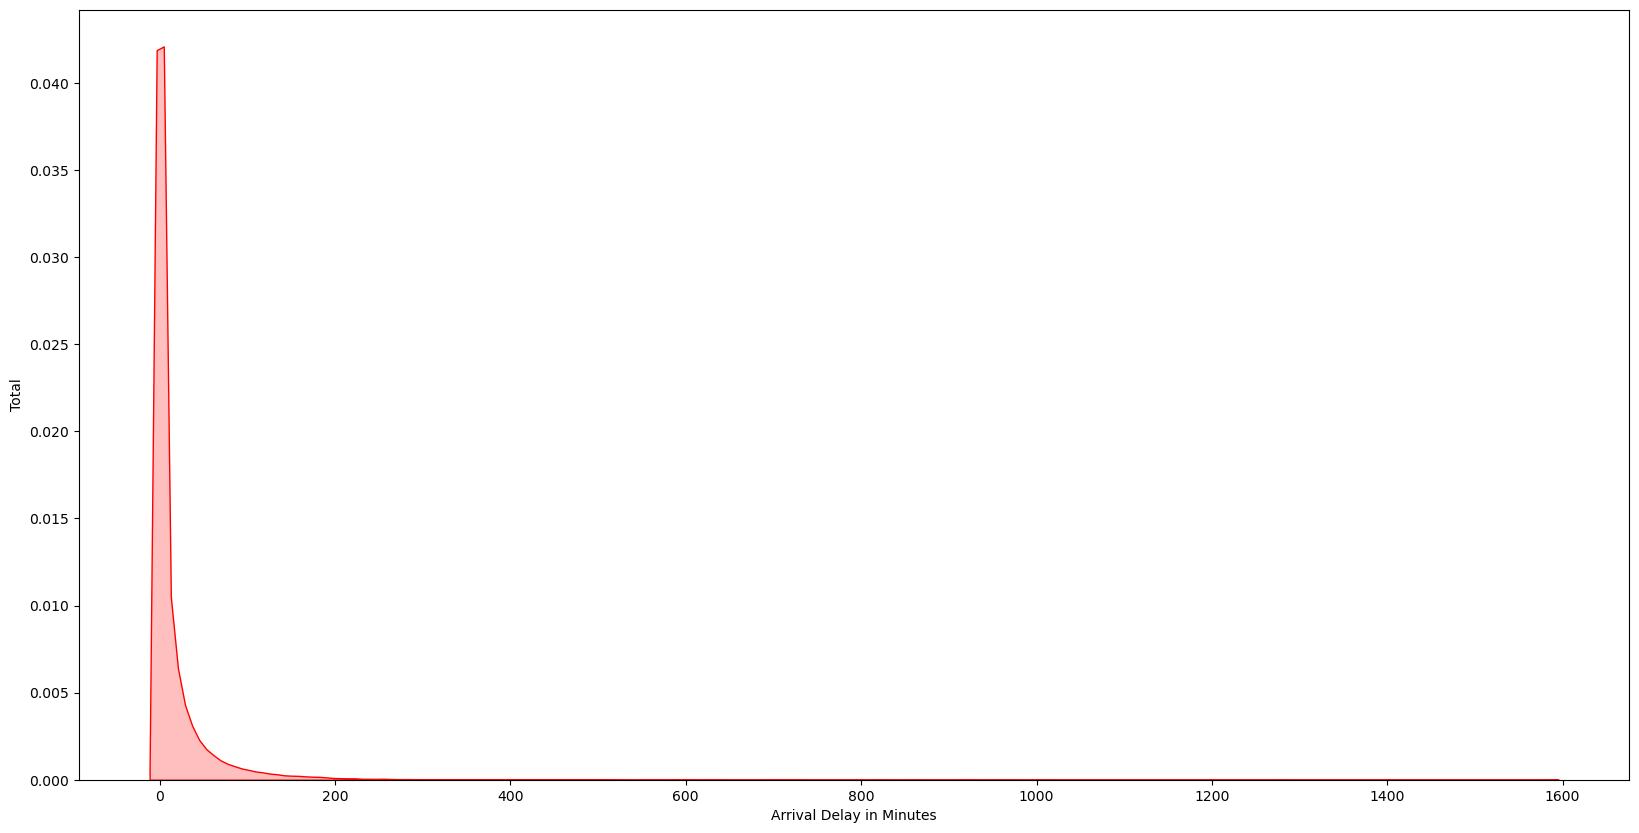

In [144]:
labels2 = ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
for label in labels2:
    plt.figure(figsize= [20,10])
    sns.kdeplot(dataset[label], color = 'red', fill = True)
    plt.xlabel(label)
    _ = plt.ylabel('Total')
    _ = plt.show()

### Análise de Outliers

Aprofundou-se a análise em busca de identificar possíveis outliers. Foi possível notar a presença de outliers em algumas classes, em sua maioria relacionados a clientes satisfeitos com níveis de serviços inferiores. 

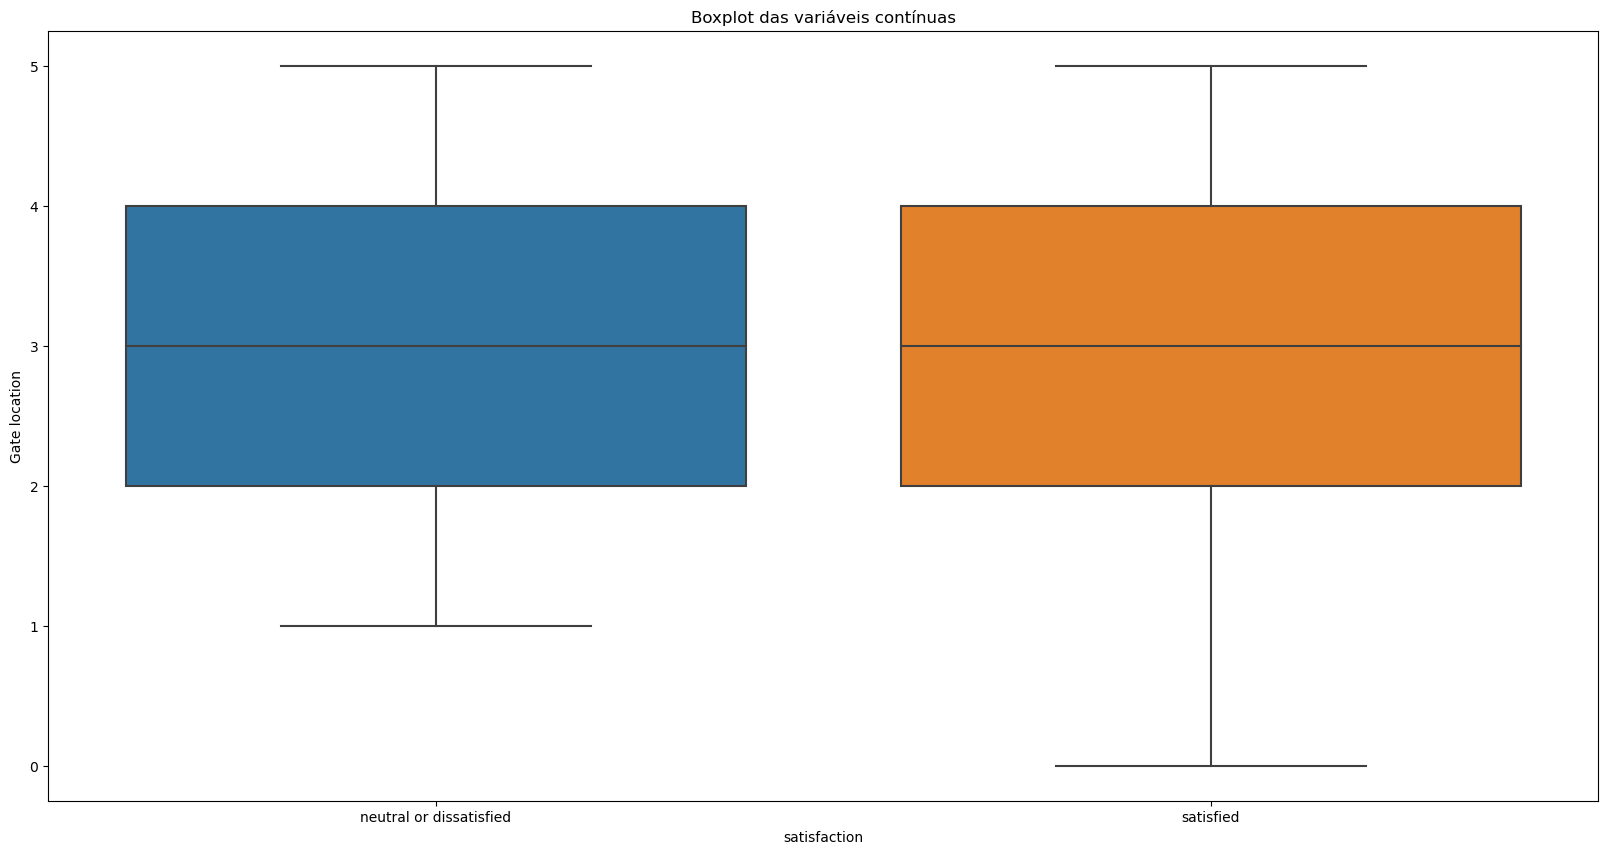

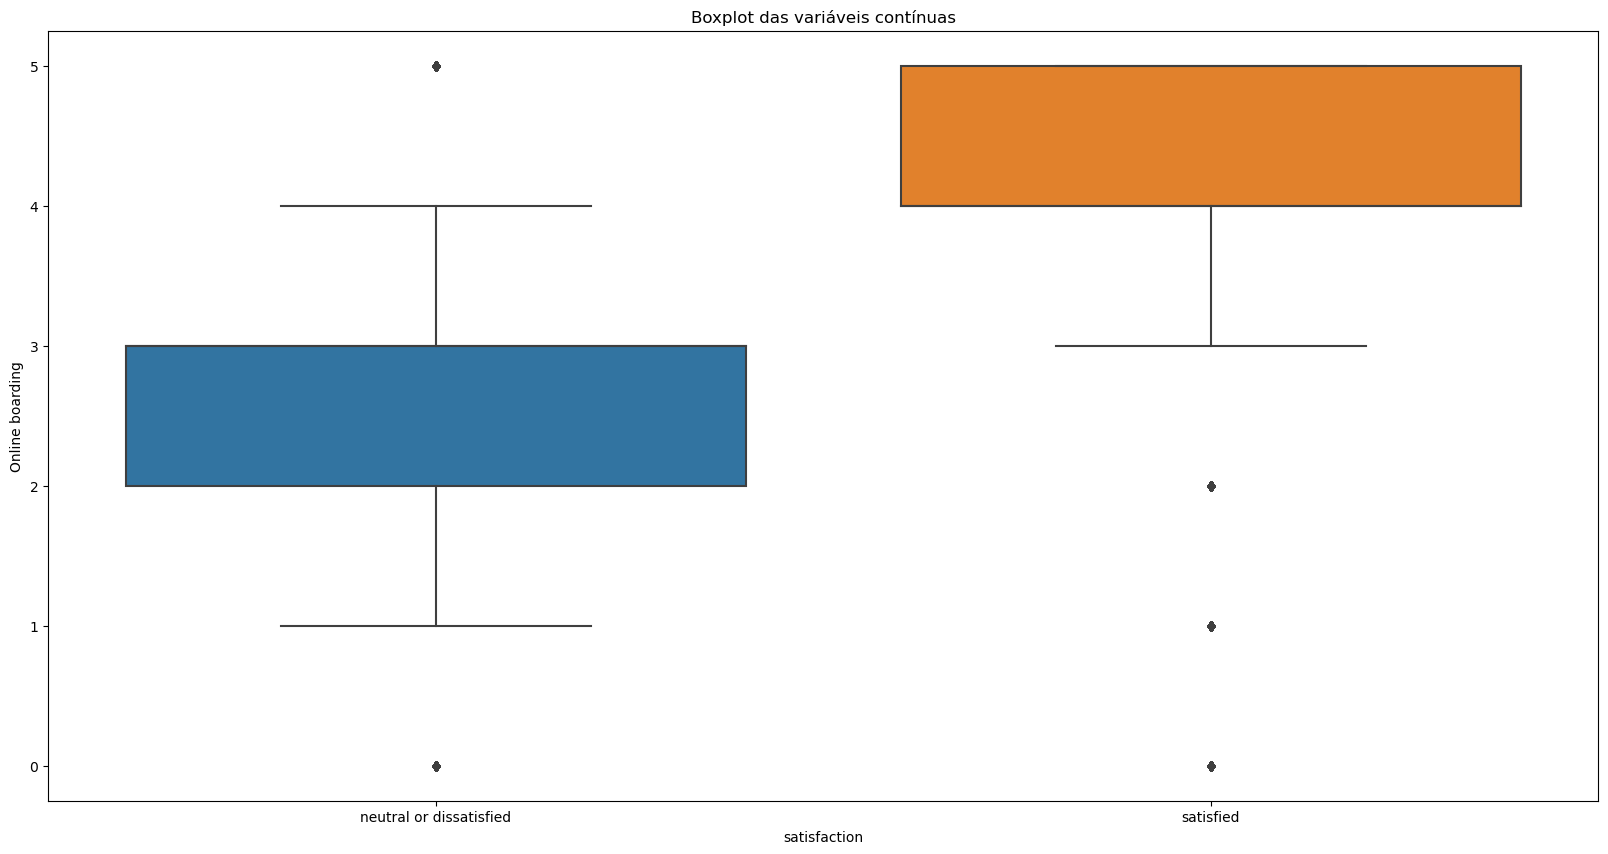

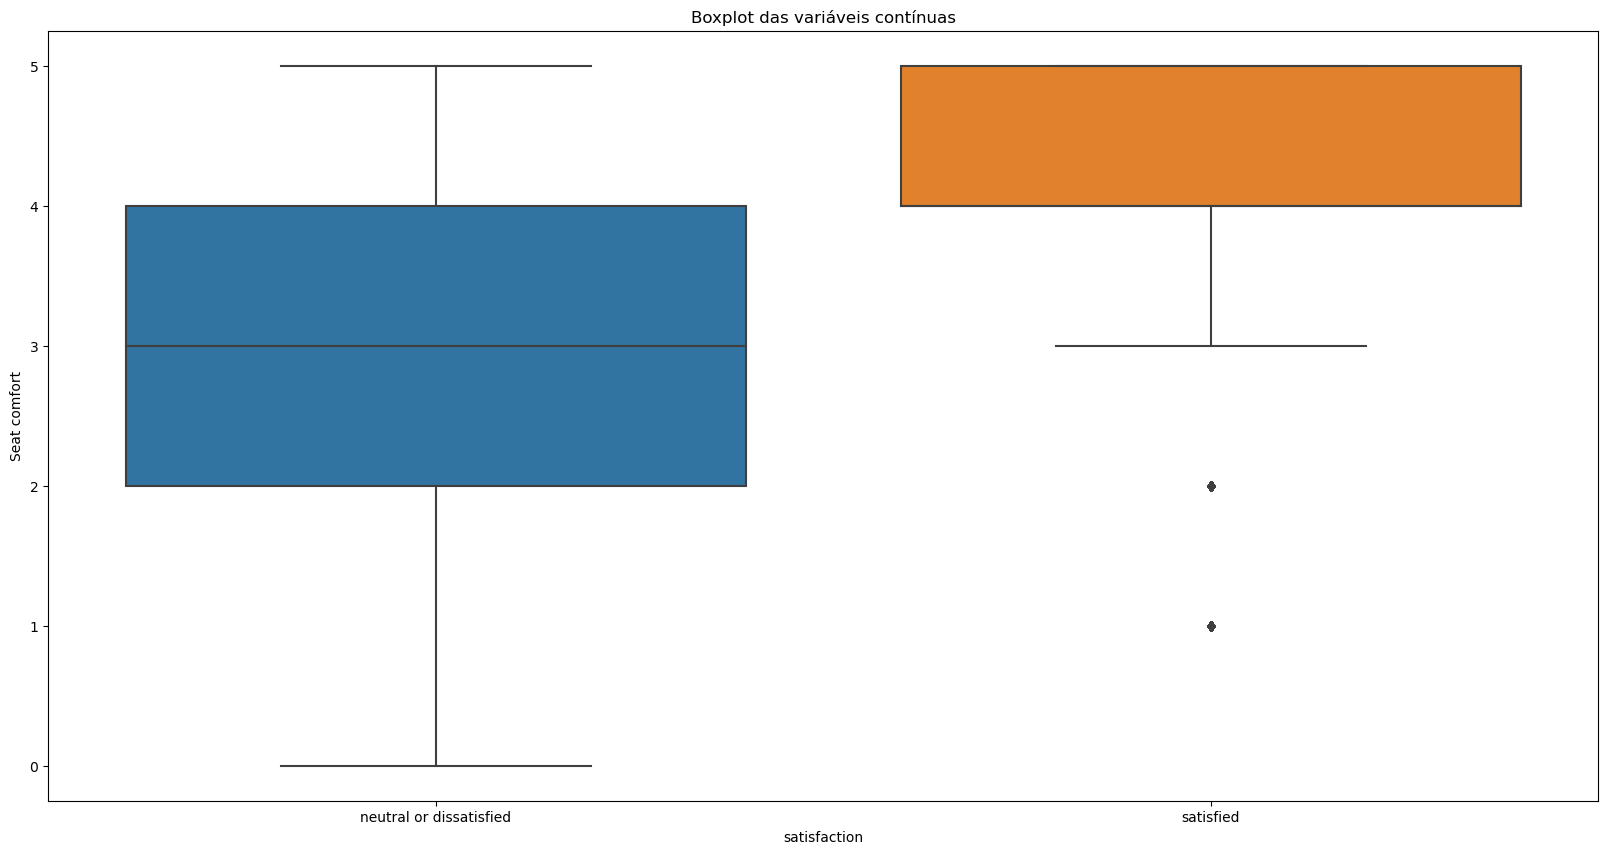

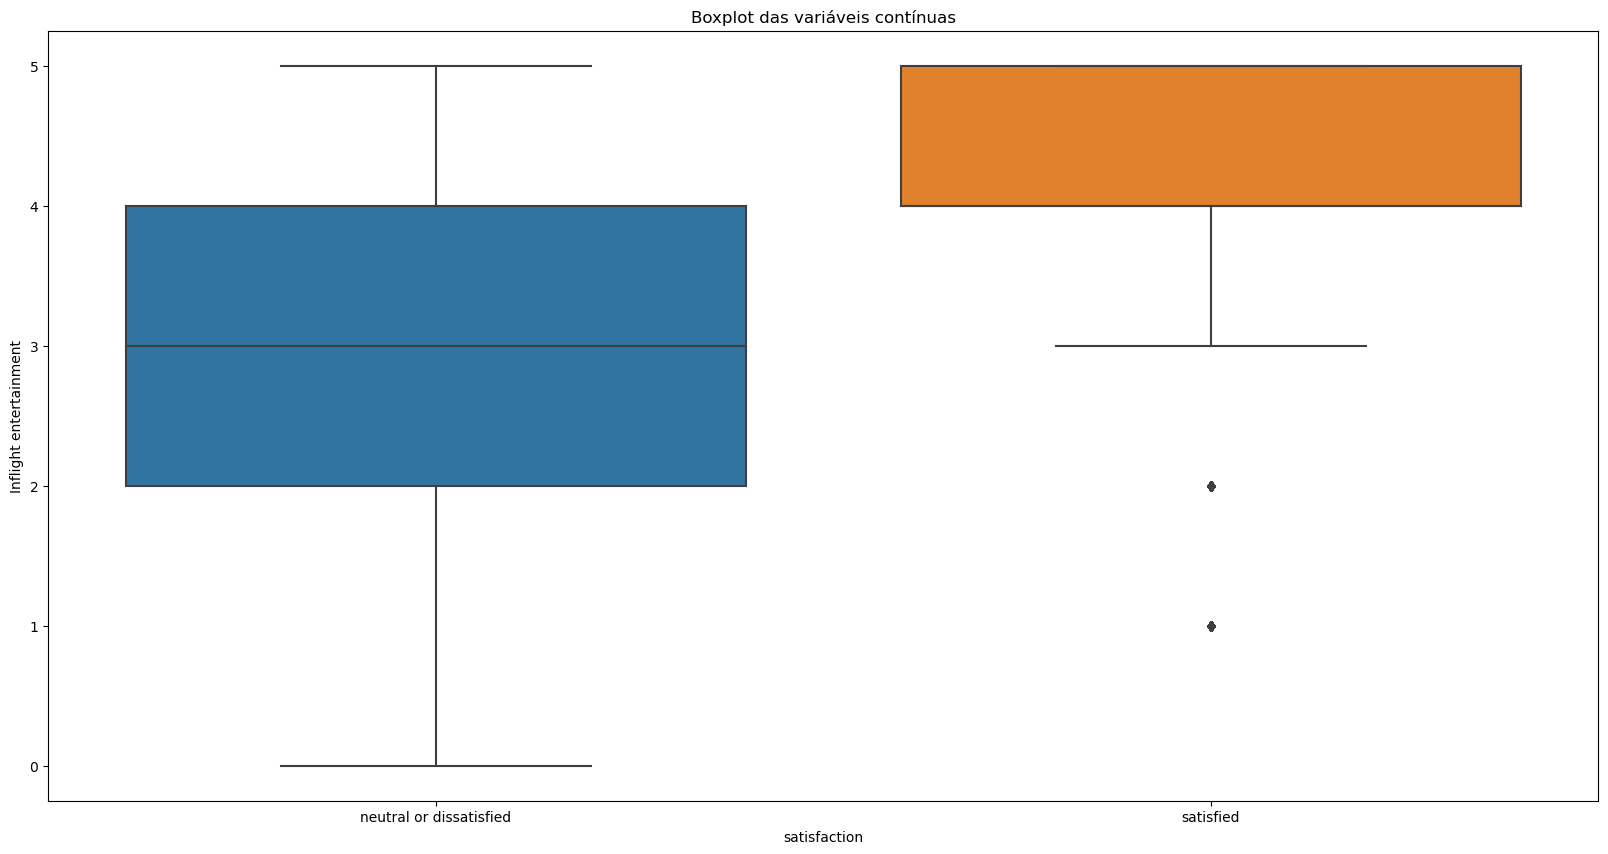

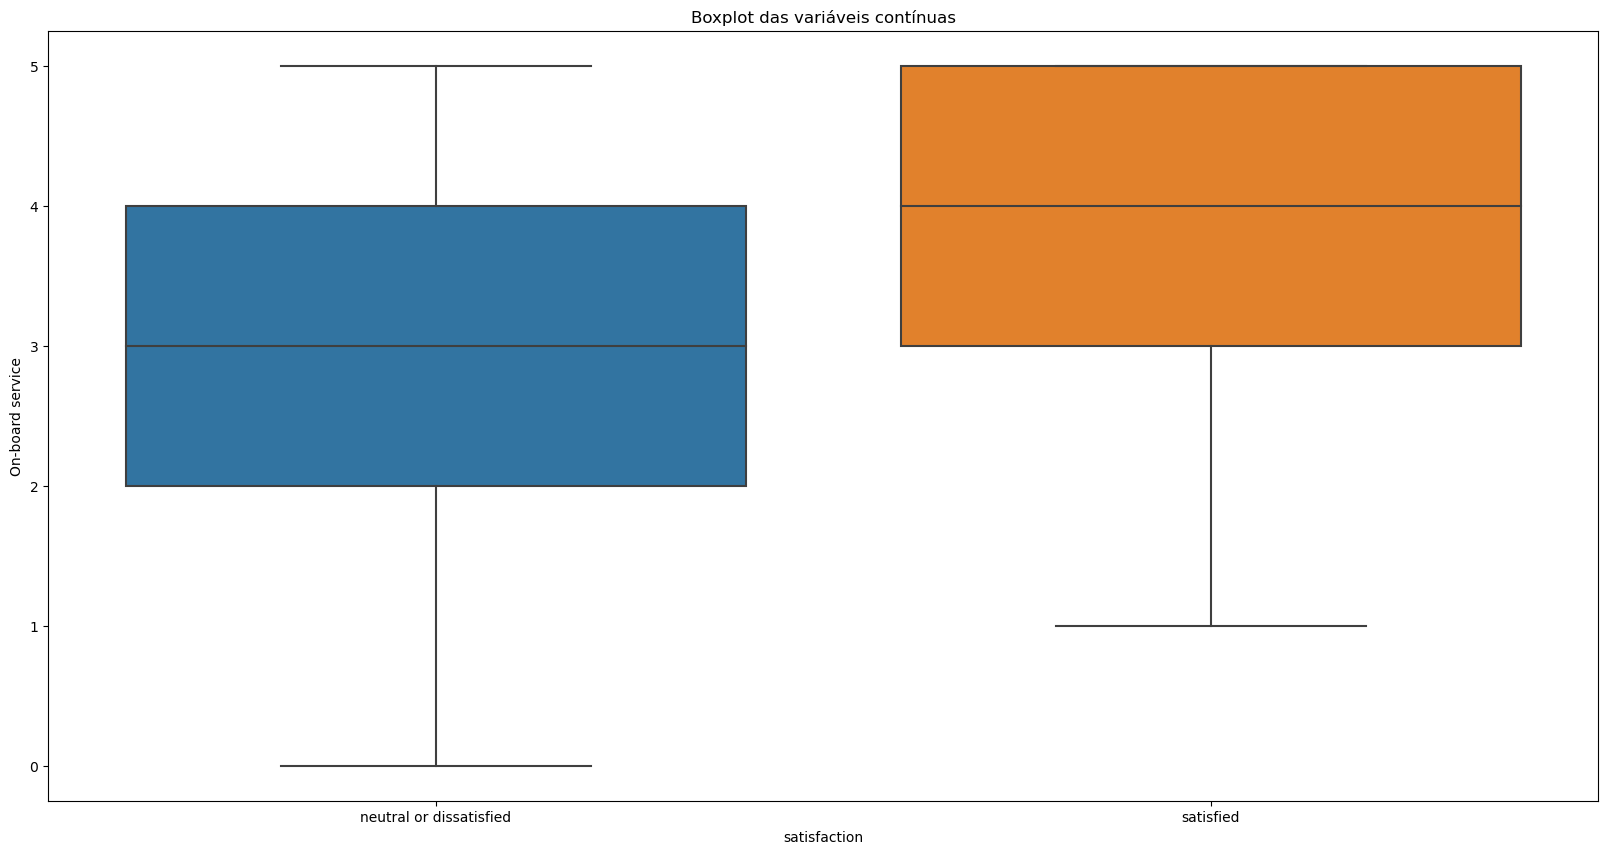

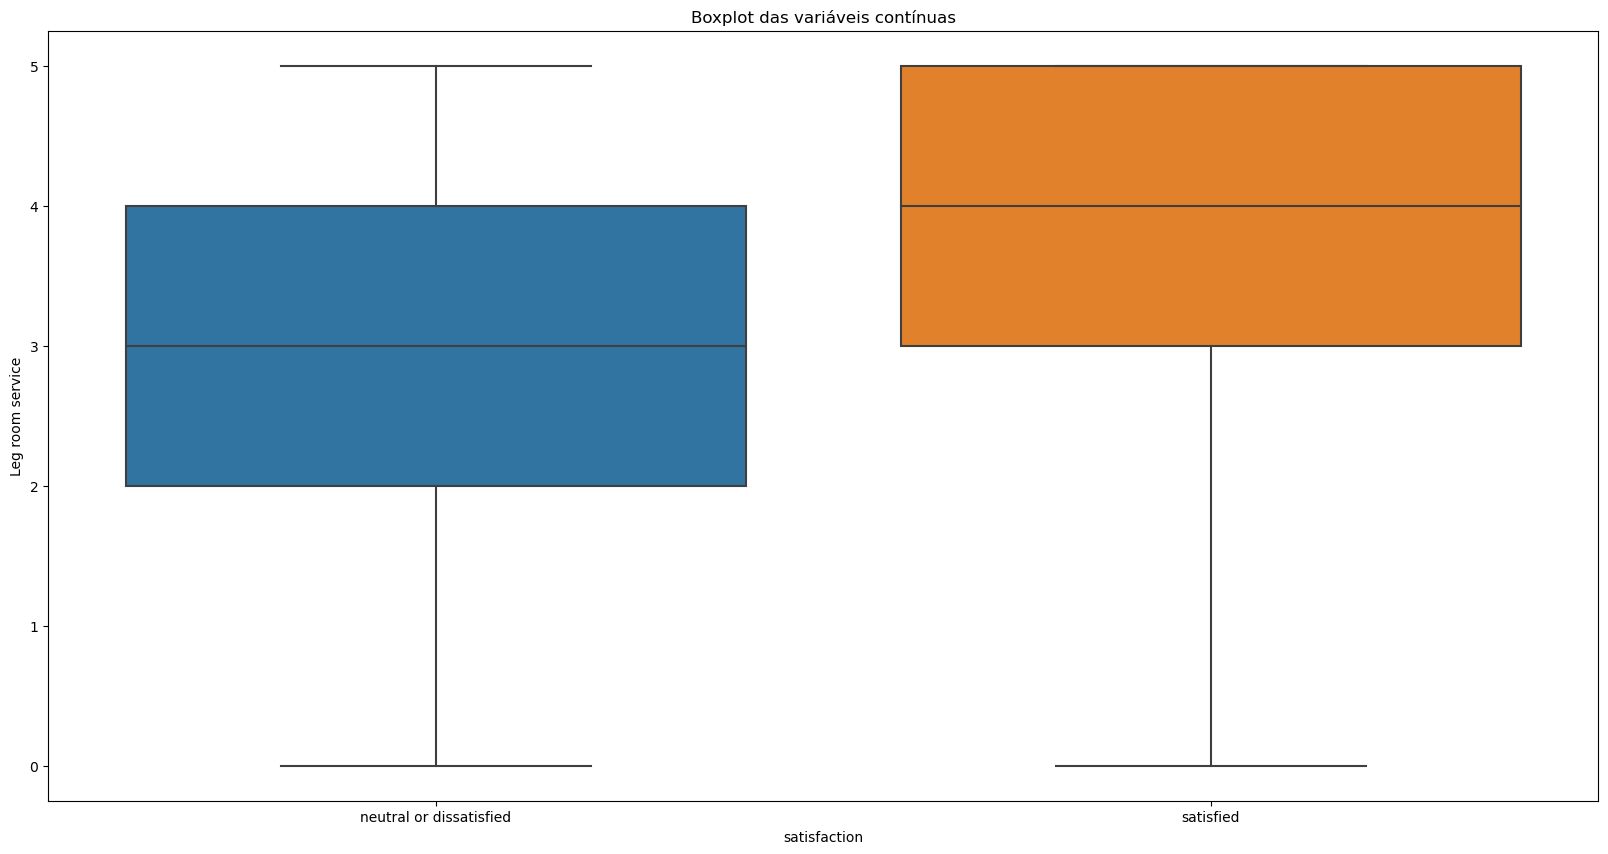

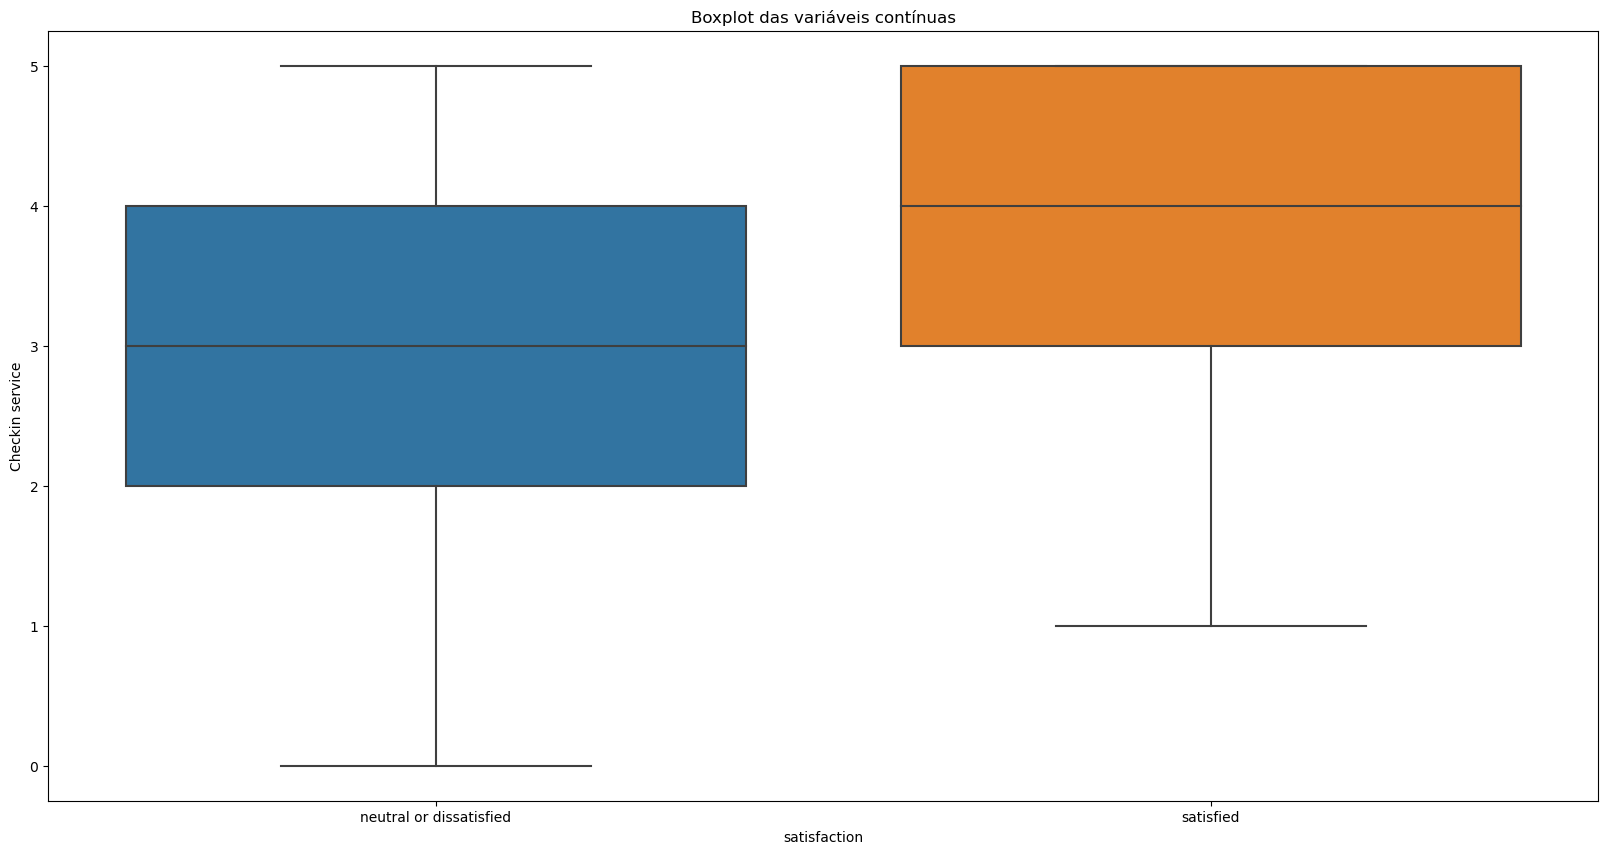

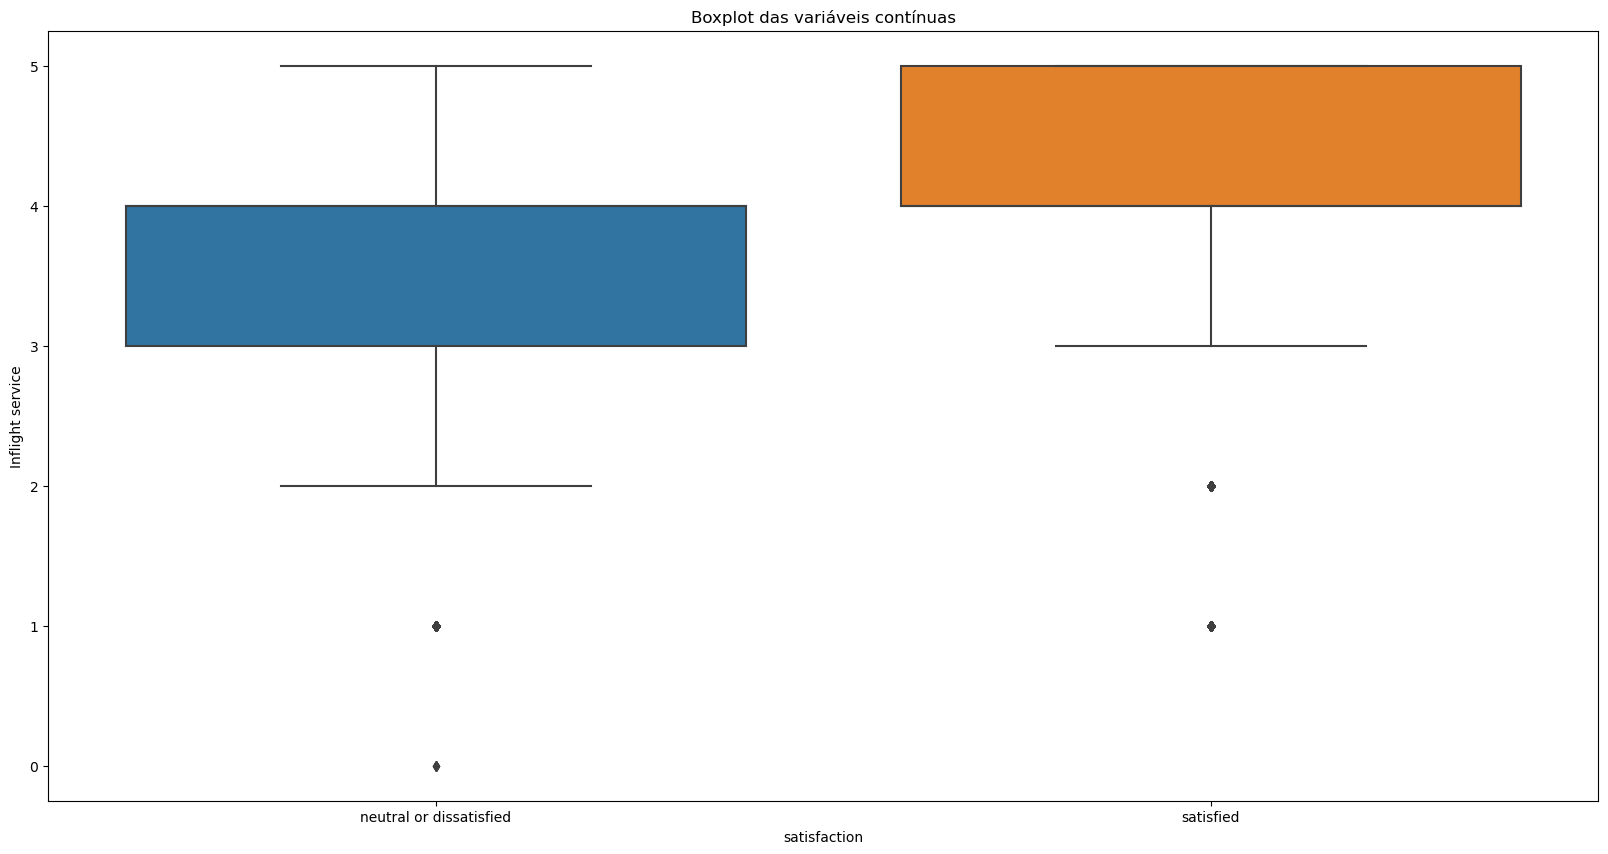

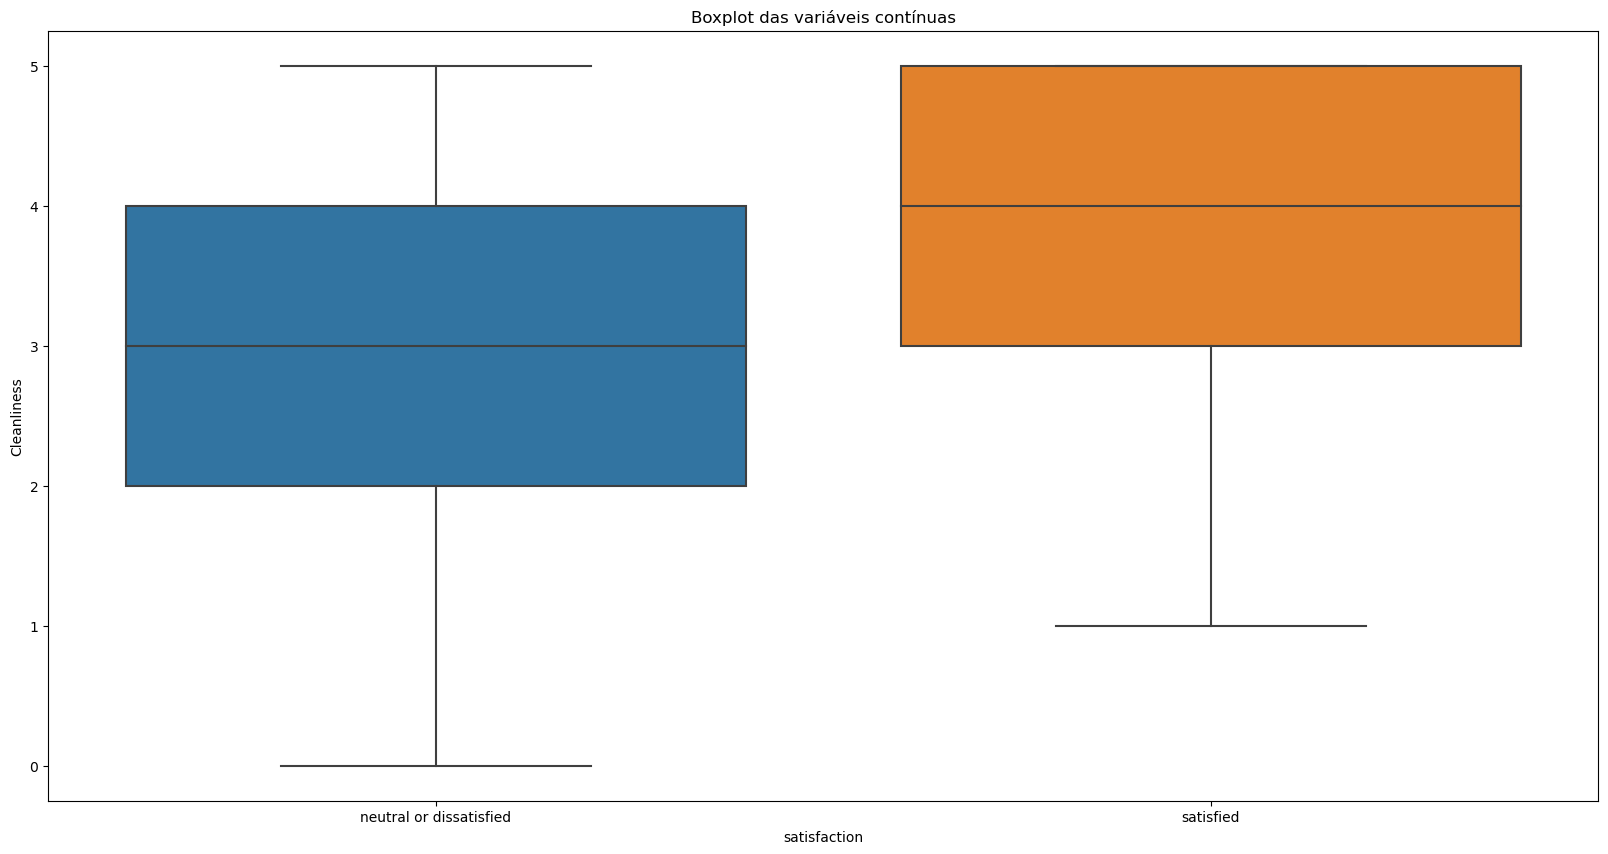

In [145]:
labels_outliers = ['Gate location', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Checkin service',  'Inflight service', 'Cleanliness']
for label in labels_outliers:
    plt.figure(figsize= [20,10])
    plt.title('Boxplot das variáveis contínuas')
    sns.boxplot(x=dataset['satisfaction'], y=dataset[label])

### Analisando correlação

Buscando entender melhor os dados traçou se uma análise de correlação dos atributos. Com isso foi possível perceber que as variáveis relativas a atraso tem uma correlação muito forte, quase atingindo o nível máximo. 

In [146]:
corr_mat = dataset.corr()
corr_mat

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
Unnamed: 0,1.000000,0.002991,0.004786,0.002794,-0.002490,0.000739,0.001913,0.005073,-0.002162,0.001002,0.000044,0.001363,0.000813,0.004052,-0.000526,-0.004321,-0.000134,-0.001117,-0.000045,-0.000045
id,0.002991,1.000000,0.022857,0.095544,-0.021276,-0.002110,0.014163,-0.000606,0.001063,0.055477,0.052903,0.002300,0.055241,0.044634,0.074940,0.079273,0.079346,0.024965,-0.019546,-0.037254
Age,0.004786,0.022857,1.000000,0.099461,0.017859,0.038125,0.024842,-0.001330,0.023000,0.208939,0.160277,0.076444,0.057594,0.040583,-0.047529,0.035482,-0.049427,0.053611,-0.010152,-0.012147
Flight Distance,0.002794,0.095544,0.099461,1.000000,0.007131,-0.020043,0.065717,0.004793,0.056994,0.214869,0.157333,0.128740,0.109526,0.133916,0.063184,0.073072,0.057540,0.093149,0.002158,-0.002426
Inflight wifi service,-0.002490,-0.021276,0.017859,0.007131,1.000000,0.343845,0.715856,0.336248,0.134718,0.456970,0.122658,0.209321,0.121500,0.160473,0.120923,0.043193,0.110441,0.132698,-0.017402,-0.019095
Departure/Arrival time convenient,0.000739,-0.002110,0.038125,-0.020043,0.343845,1.000000,0.436961,0.444757,0.004906,0.070119,0.011344,-0.004861,0.068882,0.012441,0.072126,0.093333,0.073318,0.014292,0.001005,-0.000864
Ease of Online booking,0.001913,0.014163,0.024842,0.065717,0.715856,0.436961,1.000000,0.458655,0.031873,0.404074,0.030014,0.047032,0.038833,0.107601,0.038762,0.011081,0.035272,0.016179,-0.006371,-0.007984
Gate location,0.005073,-0.000606,-0.001330,0.004793,0.336248,0.444757,0.458655,1.000000,-0.001159,0.001688,0.003669,0.003517,-0.028373,-0.005873,0.002313,-0.035427,0.001681,-0.003830,0.005467,0.005143
Food and drink,-0.002162,0.001063,0.023000,0.056994,0.134718,0.004906,0.031873,-0.001159,1.000000,0.234468,0.574556,0.622512,0.059073,0.032498,0.034746,0.087299,0.033993,0.657760,-0.029926,-0.032524
Online boarding,0.001002,0.055477,0.208939,0.214869,0.456970,0.070119,0.404074,0.001688,0.234468,1.000000,0.420211,0.285066,0.155443,0.123950,0.083280,0.204462,0.074573,0.331517,-0.018982,-0.021949


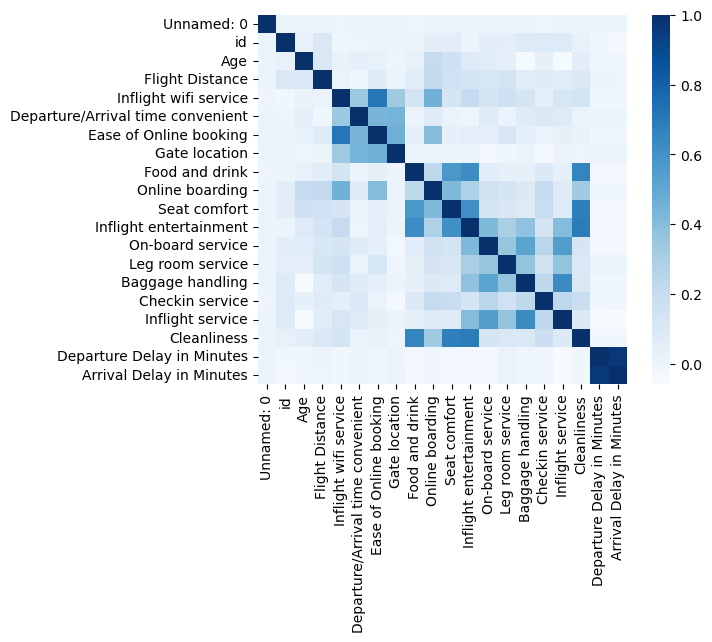

In [147]:
_ = sns.heatmap(corr_mat, square = True, cmap = 'Blues')

## Pré-processamento

Para o pré-processamento dos dados iniciou-se retirando colunas que não continham informações relevantes e linhas com valores faltantes, dado que são poucas linhas e o dataset possui mais de cem mil dados. Fora isso, dado a forte correlação entre os dois atributos relativos a atraso optou-se por usar apenas um deles, retirando o outro do dataset, em busca de reduzir um pouco a dimensionalidade do dataset.

In [148]:
# dropando colunas nao usada id e unnamed
dataset.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
dataset_test.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
dataset.head()

# removendo as linhas com dados faltantes
dataset = dataset.dropna()

In [149]:
# dropando coluna com muita correlação
dataset.drop('Departure Delay in Minutes', axis=1, inplace=True)
# coluna com dados faltantes
dataset['Arrival Delay in Minutes'].fillna(dataset['Arrival Delay in Minutes'].median(axis = 0), inplace = True)
# coluna com dados faltantes
dataset_test['Arrival Delay in Minutes'].fillna(dataset_test['Arrival Delay in Minutes'].median(axis = 0), inplace = True)

### Dropando outliers

Novamente dado o grande tamanho do dataset, optou-se por tratar o caso de outliers removendo-os dos dados que serão utilizados.

In [150]:
# Remoção dos outliers
dataset = dataset.loc[~(((dataset['Online boarding'] > 4) | (dataset['Online boarding']<1)) & (dataset['satisfaction'] == 'neutral or dissatisfied'))]

dataset = dataset.loc[~((dataset['Online boarding'] < 2) 
                      & (dataset['satisfaction'] == 'satisfied'))]

# Seat comfort
dataset = dataset.loc[~((dataset['Seat comfort'] < 2) 
                      & (dataset['satisfaction'] == 'satisfied'))]

# Inflight entertainment
dataset = dataset.loc[~((dataset['Inflight entertainment'] < 2) 
                      & (dataset['satisfaction'] == 'satisfied'))]

# Inflight service
dataset = dataset.loc[~((dataset['Inflight service'] <= 1)
                      & (dataset['satisfaction'] == 'neutral or dissatisfied'))]

dataset = dataset.loc[~((dataset['Inflight service'] < 2)
                      & (dataset['satisfaction'] == 'satisfied'))]

# On-board service
dataset = dataset.loc[~((dataset['On-board service'] < 2)
                      & (dataset['satisfaction'] == 'satisfied'))]

# Leg room service
dataset = dataset.loc[~((dataset['Leg room service'] < 2)
                      & (dataset['satisfaction'] == 'satisfied'))]

### Discretização manual das variáveis categóricas 

Realizou-se também uma discretização manual das variáveis categóricas.

In [151]:
for idx, type in enumerate(dataset['Customer Type'].unique()):
  dataset['Customer Type'] = dataset['Customer Type'].replace(type, idx)
  dataset_test['Customer Type'] = dataset_test['Customer Type'].replace(type, idx)
  print(f'{type} foi trocado por {idx} em Customer Type')

Loyal Customer foi trocado por 0 em Customer Type
disloyal Customer foi trocado por 1 em Customer Type


In [152]:
for idx, type in enumerate(dataset['Type of Travel'].unique()):
  dataset['Type of Travel'] = dataset['Type of Travel'].replace(type, idx)
  dataset_test['Type of Travel'] = dataset_test['Type of Travel'].replace(type, idx)
  print(f'{type} foi trocado por {idx} em Type of Travel')

Personal Travel foi trocado por 0 em Type of Travel
Business travel foi trocado por 1 em Type of Travel


In [153]:
for idx, type in enumerate(dataset['Class'].unique()):
  dataset['Class'] = dataset['Class'].replace(type, idx)
  dataset_test['Class'] = dataset_test['Class'].replace(type, idx)
  print(f'{type} foi trocado por {idx} em Class')

Eco Plus foi trocado por 0 em Class
Business foi trocado por 1 em Class
Eco foi trocado por 2 em Class


In [154]:
for idx, type in enumerate(dataset['Gender'].unique()):
  dataset['Gender'] = dataset['Gender'].replace(type, idx)
  dataset_test['Gender'] = dataset_test['Gender'].replace(type, idx)
  print(f'{type} foi trocado por {idx} em Gender')

Male foi trocado por 0 em Gender
Female foi trocado por 1 em Gender


In [155]:
for idx, type in enumerate(dataset['satisfaction'].unique()):
  dataset['satisfaction'] = dataset['satisfaction'].replace(type, idx)
  dataset_test['satisfaction'] = dataset_test['satisfaction'].replace(type, idx)
  print(f'{type} foi trocado por {idx} em satisfaction')

neutral or dissatisfied foi trocado por 0 em satisfaction
satisfied foi trocado por 1 em satisfaction


### Normalização dos Dados:

In [156]:
y_train = dataset['satisfaction'] 
y_test = dataset_test['satisfaction']

# Normalizando os dados de treino
scaler = StandardScaler()
scaler.fit(dataset.drop('satisfaction', axis=1))
dataset = pd.DataFrame(scaler.transform(dataset.drop('satisfaction', axis=1)),
                              columns= dataset.drop('satisfaction', axis=1).columns )

dataset.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Arrival Delay in Minutes
0,-0.994587,-0.476397,-1.751863,-1.549193,-2.254030,-0.761699,0.201464,0.633465,0.152106,-1.562541,...,-0.225192,1.178411,1.229450,0.417232,-0.369049,0.232572,0.540505,1.215008,1.315844,0.086976
1,-0.994587,2.099088,-0.950554,0.645497,-0.599744,-0.985159,0.201464,-0.703942,0.152106,0.009752,...,-0.225192,-1.930437,-1.920893,-2.079414,1.228956,-0.704726,-1.860529,0.173517,-1.773381,-0.236067
2,1.005443,-0.476397,-0.883778,0.645497,-0.599744,-0.084368,-0.594216,-0.703942,-0.604942,-0.776394,...,1.389231,1.178411,1.229450,0.417232,-0.369049,0.232572,0.540505,0.173517,1.315844,-0.397588
3,1.005443,-0.476397,-0.950554,0.645497,-0.599744,-0.660398,-0.594216,1.302169,1.666204,1.582046,...,-1.032403,-1.153225,-1.133307,-1.247199,1.228956,-0.704726,-1.860529,0.173517,-1.001074,-0.155306
4,-0.994587,-0.476397,1.453374,0.645497,-0.599744,-1.006015,0.201464,-0.035238,0.152106,0.009752,...,1.389231,1.178411,-0.345721,-0.414983,0.429954,0.232572,-0.259839,-0.867974,-0.228768,-0.397588


In [157]:
# Normalizando os dados de teste
scaler.fit(dataset_test.drop('satisfaction', axis=1))
dataset_test = pd.DataFrame(scaler.transform(dataset_test.drop('satisfaction', axis=1)),
                              columns= dataset_test.drop('satisfaction', axis=1).columns )

dataset.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Arrival Delay in Minutes
0,-0.994587,-0.476397,-1.751863,-1.549193,-2.254030,-0.761699,0.201464,0.633465,0.152106,-1.562541,...,-0.225192,1.178411,1.229450,0.417232,-0.369049,0.232572,0.540505,1.215008,1.315844,0.086976
1,-0.994587,2.099088,-0.950554,0.645497,-0.599744,-0.985159,0.201464,-0.703942,0.152106,0.009752,...,-0.225192,-1.930437,-1.920893,-2.079414,1.228956,-0.704726,-1.860529,0.173517,-1.773381,-0.236067
2,1.005443,-0.476397,-0.883778,0.645497,-0.599744,-0.084368,-0.594216,-0.703942,-0.604942,-0.776394,...,1.389231,1.178411,1.229450,0.417232,-0.369049,0.232572,0.540505,0.173517,1.315844,-0.397588
3,1.005443,-0.476397,-0.950554,0.645497,-0.599744,-0.660398,-0.594216,1.302169,1.666204,1.582046,...,-1.032403,-1.153225,-1.133307,-1.247199,1.228956,-0.704726,-1.860529,0.173517,-1.001074,-0.155306
4,-0.994587,-0.476397,1.453374,0.645497,-0.599744,-1.006015,0.201464,-0.035238,0.152106,0.009752,...,1.389231,1.178411,-0.345721,-0.414983,0.429954,0.232572,-0.259839,-0.867974,-0.228768,-0.397588


In [158]:
# Função para padronizar o plot da matriz de confusão
def plot_cf(c_matrix, classifier):
  class_names = ['neutral or dissatisfied', 'satisfied']
  fig = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=class_names)
  f, ax = plt.subplots(figsize=(10,10))
  fig.plot(cmap='Blues', values_format='g', ax=ax)
  plt.title('Confusion Matrix - %s ' % classifier)
  
  plt.show()

## Separando treino e teste
O dataset já vem separado por padrão em dois arquivos diferentes, foi dicidido manter essa divisão, portanto aqui apenas atribuímos as variáveis corretas para os datasets designados

In [159]:
scores_list = list()

X_train = dataset
X_test = dataset_test.drop(['Departure Delay in Minutes'], axis=1)

## Classificadores e Resultados
Os algoritmos classificadores escolhidos foram:

- Árvore de Decisão
- K-Vizinhos
- Perceptron Multicamadas
- Rede Neural Artificial implementada manualmente

Foram escolhidos tais classificadores em busca de analisar o desempenho individual das implementações dos modelos disponíveis nas principais bibliotecas da linguagem Python e analisar o desempenho de uma implementação manual de uma rede neural, com auxílio das implementações de funções da bibliotecas PyTorhc, em busca de traçar um contraponto com a combinação dos resultados dos modelos. 

Como métrica para analise dos resultados foi decidido observar a `acurácia balanceada` e a `matriz de confusão`.

## Árvore de decisão

In [160]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

dtc_pred = dtc.predict(X_test)
dtc_proba = dtc.predict_proba(X_test)

c_matrix_tree = confusion_matrix(y_test, dtc_pred)
print(classification_report(dtc_pred, y_test))

dtc_results = balanced_accuracy_score(y_test, dtc_pred)
print(dtc_results)
scores_list.append(dtc_results)

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     15078
           1       0.85      0.89      0.87     10898

    accuracy                           0.88     25976
   macro avg       0.88      0.88      0.88     25976
weighted avg       0.89      0.88      0.88     25976

0.8800808768206662


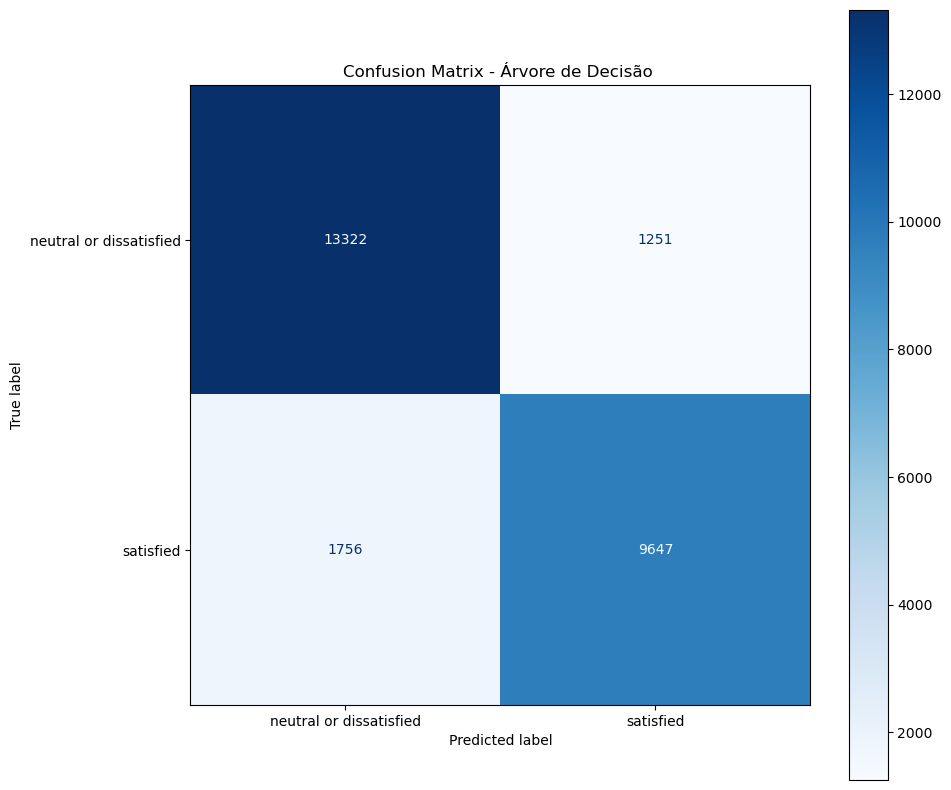

In [161]:
plot_cf(c_matrix_tree, classifier='Árvore de Decisão')

### Análise dos resultados

A árvore de decisão se mostrou um classificador bastante apto a classificar negativos, mostrando uma boa acurácia final. Entranto, seus maiores erros ficaram por conta de classificações falso negativas. 

## K-Vizinhos

In [162]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

knc_pred = knc.predict(X_test)
knc_proba = knc.predict_proba(X_test)

c_matrix_knc = confusion_matrix(y_test, knc_pred)
print(classification_report(knc_pred, y_test))

knc_result = balanced_accuracy_score(y_test, knc_pred)
print(knc_result)
scores_list.append(knc_result)

/home/fonta42/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.97      0.88      0.92     15927
           1       0.84      0.95      0.89     10049

    accuracy                           0.91     25976
   macro avg       0.90      0.92      0.91     25976
weighted avg       0.92      0.91      0.91     25976

0.9026448049912695


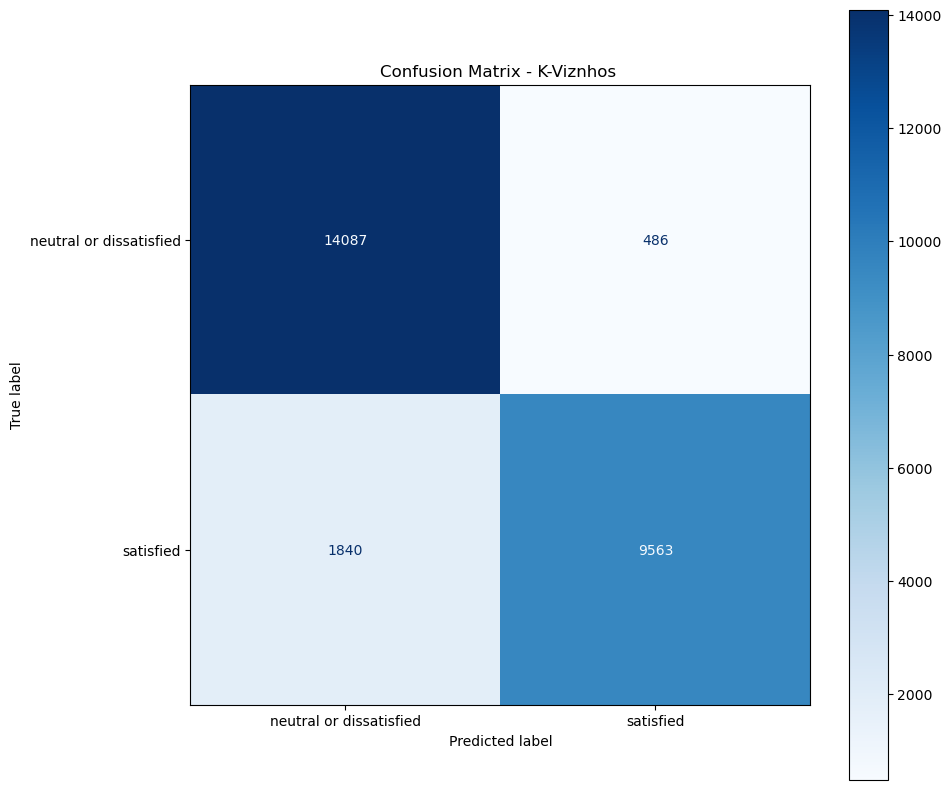

In [163]:
plot_cf(c_matrix_knc, classifier='K-Viznhos')

### Análise dos resultados 

O classificador KNN se mostrou um pouco mais preciso que a árvore de decisão, também tendo bom desempenho em classificar negativo, contudo sofre do mesmo problema de classificar falsos negativos.

## Perceptron Multicamadas

In [164]:
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

mlp_pred = mlp.predict(X_test)
mlp_proba = mlp.predict_proba(X_test)

c_matrix_mlp = confusion_matrix(y_test, mlp_pred)
print(classification_report(mlp_pred, y_test))
mlp_result = balanced_accuracy_score(y_test, mlp_pred)
print(mlp_result)
scores_list.append(mlp_result)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     15397
           1       0.88      0.95      0.92     10579

    accuracy                           0.93     25976
   macro avg       0.93      0.93      0.93     25976
weighted avg       0.93      0.93      0.93     25976

0.9252590382846024


/home/fonta42/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


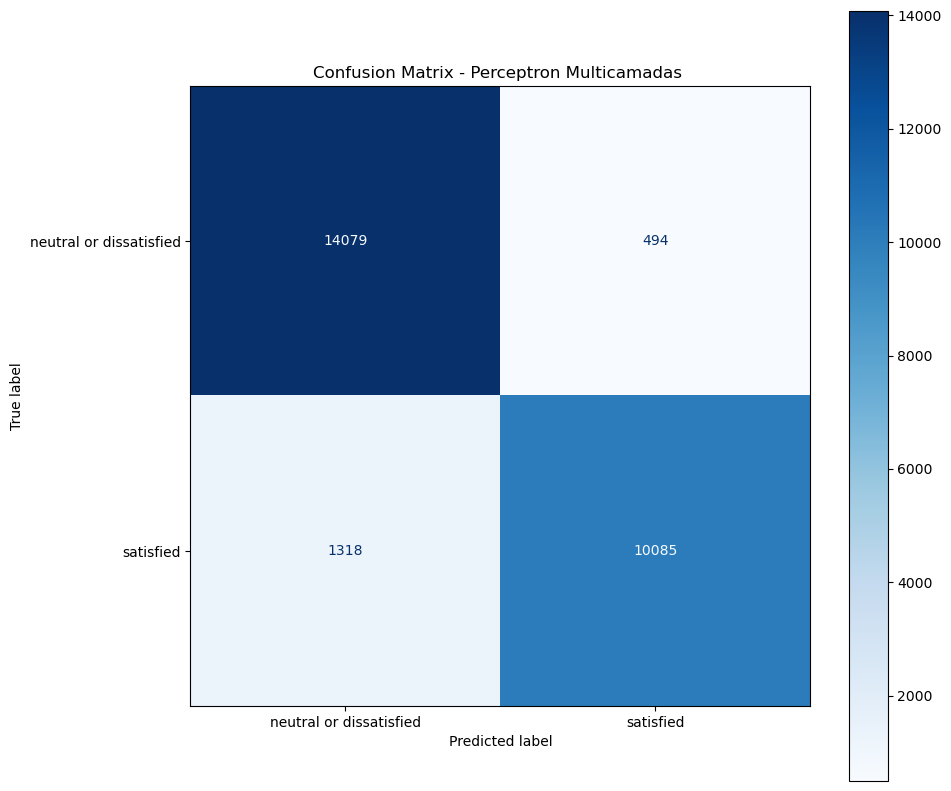

In [165]:
plot_cf(c_matrix_mlp, classifier='Perceptron Multicamadas')

### Análise dos resultados 

Os resultados do classificador MLP se mostrou o melhor obtido, com uma acurácia de aproximadamente 93%, mas o mesmo também demonstra o comportamento de classificar falsos negativos, porém de forma menos acentuada.

## Resumo dos Resultados dos Classificadores

Os três classificadores obtiveram resultados semelhantes, sendo o melhor deles o `Perceptron Multicamadas` com uma acurácia balanceada de cerca de 92%. Outro deralhe interessante de ser observado é que houve também uma pequena predominância nos falsos negativos em relação aos erros totais, no entanto como todos os classificadores atingiram altas taxas de acertos, esse leve desbalanceamento não acarretará em um prejuízo ao se aplicar os algoritmos de combinação.

## Rede Neural Artificial

Por fim, optou-se por implementar uma rede neural artificial simi-manualmente para teste e análises de desempenho em contraponto a implementação disponível do MLP. Foi escolhida como função de propagração a função ReLU. Ademais, foi definido 2500 épocas de treino para ajuste do modelo, pois dados os teste feitos a partir de tal quantidade de épocas o desempenho pouco muda.

In [166]:
# Convertendo de numpy para tensor
X_train_rna = torch.from_numpy(X_train.values).type(torch.FloatTensor)
X_test_rna = torch.from_numpy(X_test.values).type(torch.FloatTensor)
y_train_rna = torch.from_numpy(y_train.values.squeeze()).type(torch.LongTensor)
y_test_rna = torch.from_numpy(y_test.values.squeeze()).type(torch.LongTensor)

# Escolhendo a gpu caso esteja disponível
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [167]:
# Verificando as dimensões dos dados
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(85850, 21)
(25976, 21)
(85850,)
(25976,)


In [168]:
# Criação da rede neural artificial
class RedeNeuralArtificial(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(RedeNeuralArtificial, self).__init__()
        self.input = nn.Linear(input_num, hidden_num)
        self.hidden = nn.Linear(hidden_num, hidden_num) # Camada oculta
        self.output = nn.Linear(hidden_num, output_num) # Camada de saída
        self.sigmoid = nn.Sigmoid() # Função de ativação sigmoid
        self.relu = nn.ReLU() # Função de ativação ReLU
    
    # Funcao de propragação
    def forward(self, x):
        x = self.relu(self.input(x))
        x = self.relu(self.hidden(x))
        return self.output(x)
    
    # Funcao de predicao do modelo
    def predict(self, x):
        # Aplicando a função de ativação sigmoid
        predictions = self.sigmoid(self.forward(x))
        result = []
        # Selecionando a classe com maior probabilidade
        for current_value in predictions:
            if current_value[0] > current_value[1]:
                result.append(0)
            else:
                result.append(1)
        return result

In [169]:
input_num = 21 # Quantidade de atributos como entrada
hidden_num = 21
output_num = 2  # A dimensionalidade da saída é igual ao número de classes

# Declarando o modelo
rna = RedeNeuralArtificial(input_num, hidden_num, output_num)
rna.to(device)
print(rna)

RedeNeuralArtificial(
  (input): Linear(in_features=21, out_features=21, bias=True)
  (hidden): Linear(in_features=21, out_features=21, bias=True)
  (output): Linear(in_features=21, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)


In [170]:
# Definindo a função de perda e o otimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rna.parameters(), lr = 0.01)

In [171]:
# Transfere os dados para a GPU, caso disponível
if torch.cuda.is_available():
    X_train_rna = Variable(X_train_rna).cuda()
    y_train_rna = Variable(y_train_rna).cuda()
    X_test_rna = Variable(X_test_rna).cuda()
    y_test_rna = Variable(y_test_rna).cuda()

num_epochs = 2500 # Numero de épocas
epochs = []
losses = []
# Treinamento da rede reunal
for epoch in range(num_epochs):
    # forward propagation
    y_pred_rna = rna(X_train_rna)
    loss = criterion(y_pred_rna, y_train_rna)
    
    # back propagation
    optimizer.zero_grad() # Zera os gradientes para evitar acumulação
    loss.backward() # Calcula os gradientes
    optimizer.step() # Atualiza os pesos
    
    epochs.append(epoch)
    losses.append(loss.item())
    if epoch % 125 == 0:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch, num_epochs, loss.item()))
        
        
print('\nTraining Complete')

Epoch [0/2500], Loss: 0.74354
Epoch [125/2500], Loss: 0.10382
Epoch [250/2500], Loss: 0.08676
Epoch [375/2500], Loss: 0.07816
Epoch [500/2500], Loss: 0.07298
Epoch [625/2500], Loss: 0.07077
Epoch [750/2500], Loss: 0.06965
Epoch [875/2500], Loss: 0.06835
Epoch [1000/2500], Loss: 0.06744
Epoch [1125/2500], Loss: 0.06702
Epoch [1250/2500], Loss: 0.06662
Epoch [1375/2500], Loss: 0.06604
Epoch [1500/2500], Loss: 0.06589
Epoch [1625/2500], Loss: 0.06533
Epoch [1750/2500], Loss: 0.06523
Epoch [1875/2500], Loss: 0.06514
Epoch [2000/2500], Loss: 0.06468
Epoch [2125/2500], Loss: 0.06435
Epoch [2250/2500], Loss: 0.06365
Epoch [2375/2500], Loss: 0.06359

Training Complete


### Análise da função de perda

É possível perceber que a grande queda na função de perda ocorre entre as primeiras 500 épocas de treinamento, sendo que a partir de 2500 épocas a queda se torna praticamente irrisória.

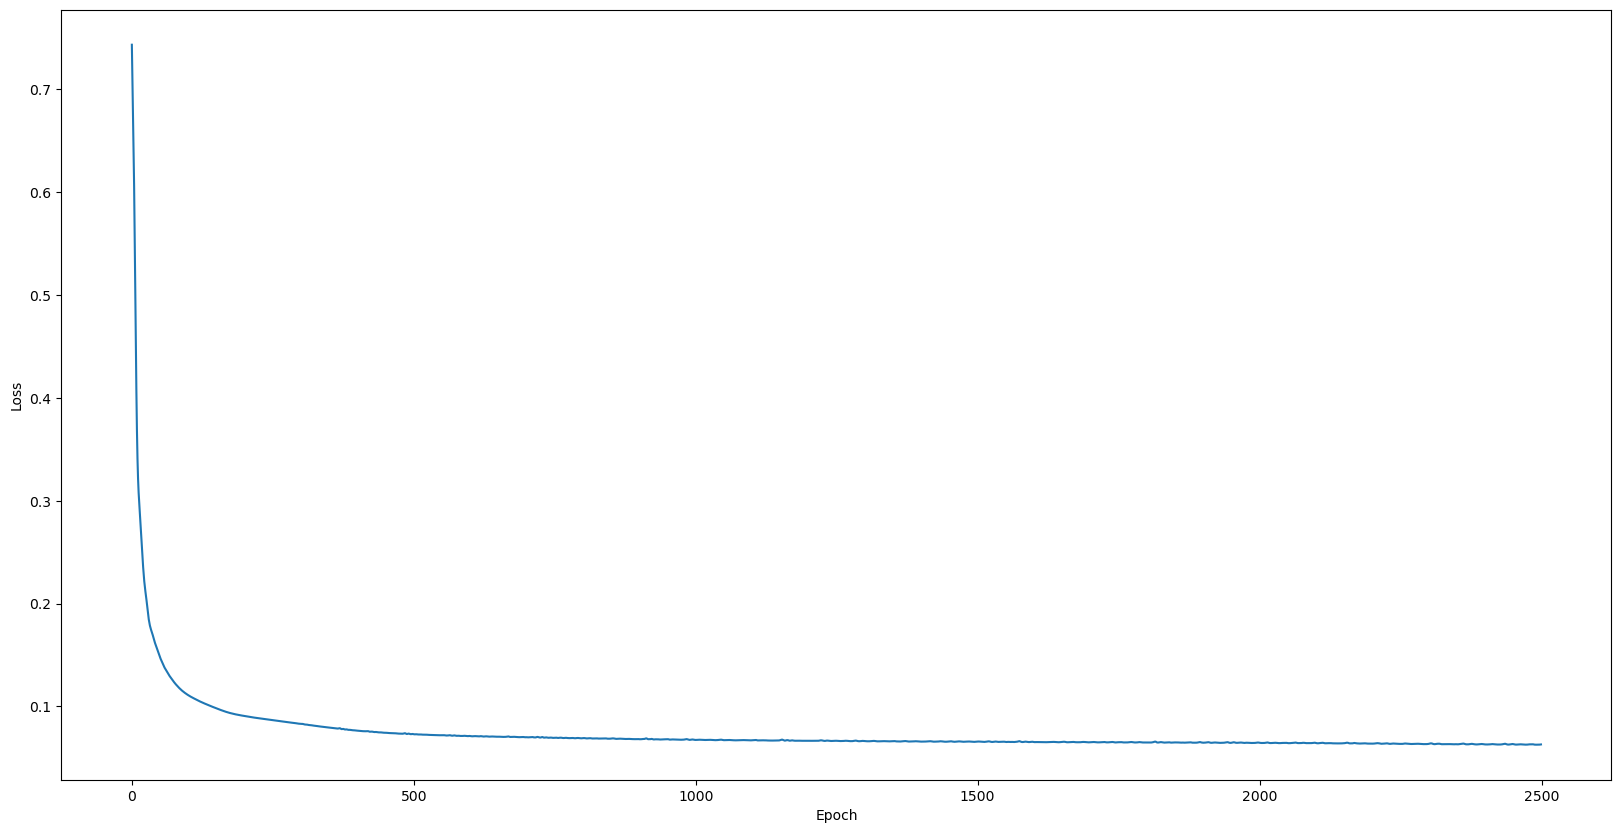

In [173]:
plt.figure(figsize= [20,10])
plt.plot(epochs, losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
_ = plt.show()

In [174]:
rna_pred = rna.predict(X_test_rna)

X_test_rna = X_test_rna.cpu().numpy() # Converte o tensor para numpy
y_test_rna = y_test_rna.cpu().numpy()
rna_pred_rna = np.array(rna_pred) # Converte a lista para numpy

print(classification_report(rna_pred, y_test_rna))
rna_results = balanced_accuracy_score(rna_pred, y_test_rna)
rna_results = balanced_accuracy_score(rna_pred, y_test_rna)
scores_list.append(rna_results)
rna_results

              precision    recall  f1-score   support

           0       0.95      0.90      0.93     15303
           1       0.87      0.93      0.90     10673

    accuracy                           0.92     25976
   macro avg       0.91      0.92      0.91     25976
weighted avg       0.92      0.92      0.92     25976



0.9176213674689171

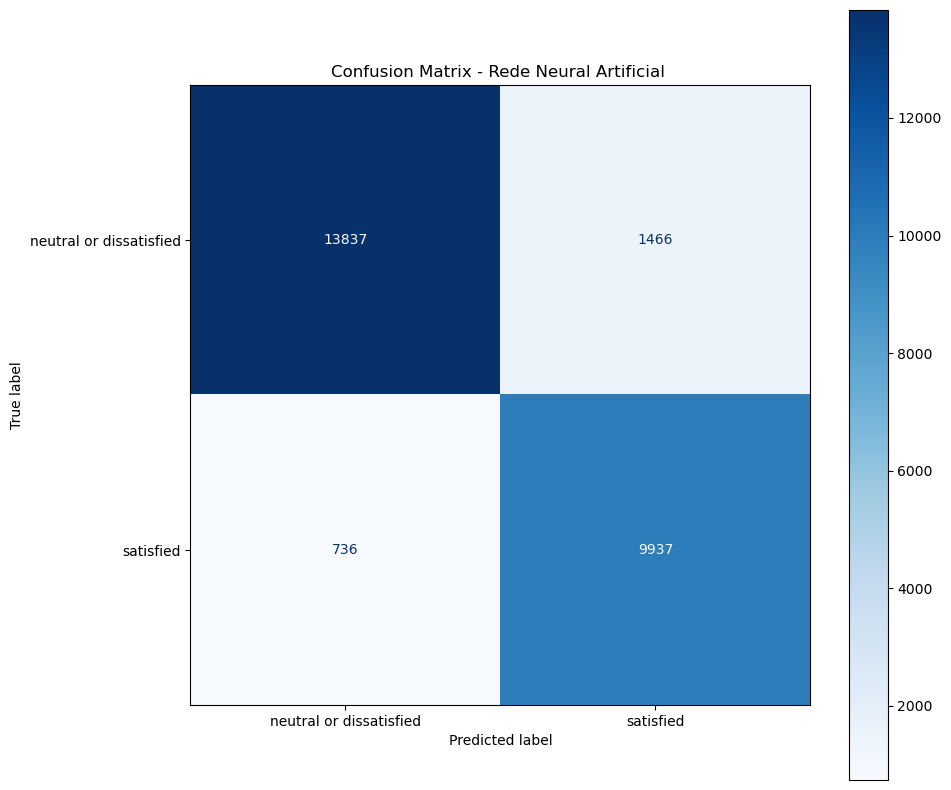

In [175]:
# Matriz de confusão da rede neural
c_matrix_rna = confusion_matrix(rna_pred, y_test_rna)
plot_cf(c_matrix_rna, classifier='Rede Neural Artificial')

### Análise dos resultados


A Rede Neural Artificial se mostrou bastante apta a fazer a classificação tendo uma média de precisão de 91% e uma acurácia balanceada de 92%. Ela mostrou como pior desempenho uma precisão de 87% em classificar clientes neutros ou não satisfeitos, tendo um erro maior em classificar cliente dessa classe como satisfeitos.

## Combinação

### Votação Simples

Esse algoritmo realiza a combinação através da votação majoritária, ou seja, a classe que foi escolhida como correta pela maioria dos classificadores combinados é selecionada.

In [184]:
voting_pred = mode(np.vstack( [dtc_pred, knc_pred, mlp_pred, rna_pred] ) )

voting_results = balanced_accuracy_score(y_test, voting_pred[0][0])
c_matrix_voting = confusion_matrix(y_test, voting_pred[0][0])
print(classification_report(voting_pred[0][0], y_test))
print(voting_results)
scores_list.append(voting_results)

/tmp/ipykernel_6707/1998715576.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  voting_pred = mode(np.vstack( [dtc_pred, knc_pred, mlp_pred, rna_pred] ) )


              precision    recall  f1-score   support

           0       0.98      0.90      0.94     15856
           1       0.86      0.97      0.91     10120

    accuracy                           0.93     25976
   macro avg       0.92      0.93      0.92     25976
weighted avg       0.93      0.93      0.93     25976

0.9188885875816941


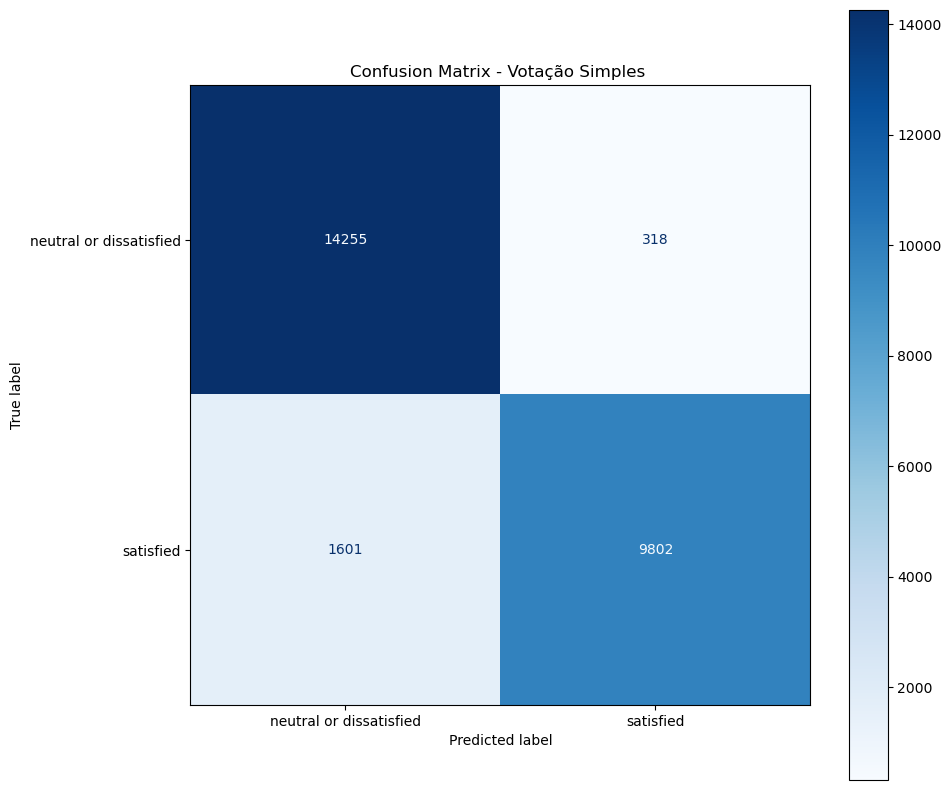

In [177]:
plot_cf(c_matrix_voting, classifier='Votação Simples')

### Análise dos resultados

Como era de se esperar a votação simples absorveu o comportamento dos classificadores em errar predominantemente em classificar falsos negativos, contudo a soma das predições demonstrou uma melhor nos resultados em relação a maioria dos classificadores individualmente.

## Probabilidades ou Scores

Esse outro modelo de combinação utiliza os `scores` atribuídos aos valores pelos classificadores, esses `scores` funcionam como probabilidades das classes serem as corretas e então são somados pelos algoritmos para que a classe com a maior probabilidade seja selecionada. Tal técnica foi aplicada apenas nos classificadores com implementação já pronta e disponível na Sklearn, dado que rede neural artificial implementada manualmente requer uma manipulação diferente para seus dados.

In [185]:
sum_proba = dtc_proba + knc_proba + mlp_proba

prob_results = balanced_accuracy_score(y_test, np.argmax(sum_proba, axis=1))

c_matrix_prob = confusion_matrix(y_test, np.argmax(sum_proba, axis=1))
print(classification_report(np.argmax(sum_proba, axis=1), y_test))
print(prob_results)
scores_list.append(prob_results)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     15509
           1       0.88      0.95      0.91     10467

    accuracy                           0.93     25976
   macro avg       0.92      0.93      0.93     25976
weighted avg       0.93      0.93      0.93     25976

0.9219112126589173


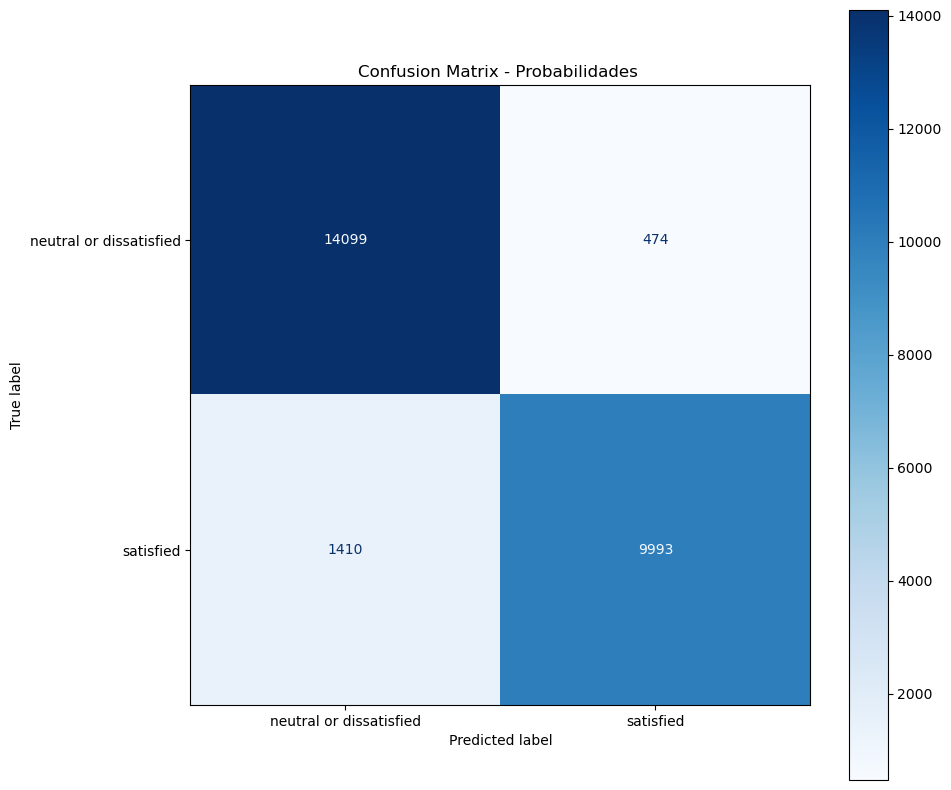

In [179]:
plot_cf(c_matrix_prob, classifier='Probabilidades')

### Análise dos resultados

A soma de probabilidades demonstrou uma melhora na questão da classificação de falsos negativos, mesmo ainda sendo a principal fonte de erro. Do mais, ela também demonstra uma melhor no desempenho em relação aos classificadores individualmente.

### Resultados da combinação

Ambos os métodos de combinação atingiram valores semelhantes, em torno de 92% de acurária balanceada e suas respectivas matrizes de confusão também apresentam muitas semelhanças.

Além disso, é interessante observar que a leve predominância dos falsos negativos encontrada nos classsificadores é transportada para os resultados finais da combinação, como pode ser verificado através das matrizes de confusão. Esse é um comportamento esperado pelo modo como a combinação funciona e não apresenta prejuízo nos resultados finais.

## Plot dos resultados

Para uma melhor visualização e compreensão dos resultados, é interessante olhar através de um gráfico os valores da acurácia balanceada de todos os classificadores e também dos algoritmos de combinação. Nesse experimento todos os resultados atingidos foram bem elevados, sendo o menor deles de quase 88% na `Árvore de Decisão` e todos os outros ultrapassaram os 90%. 

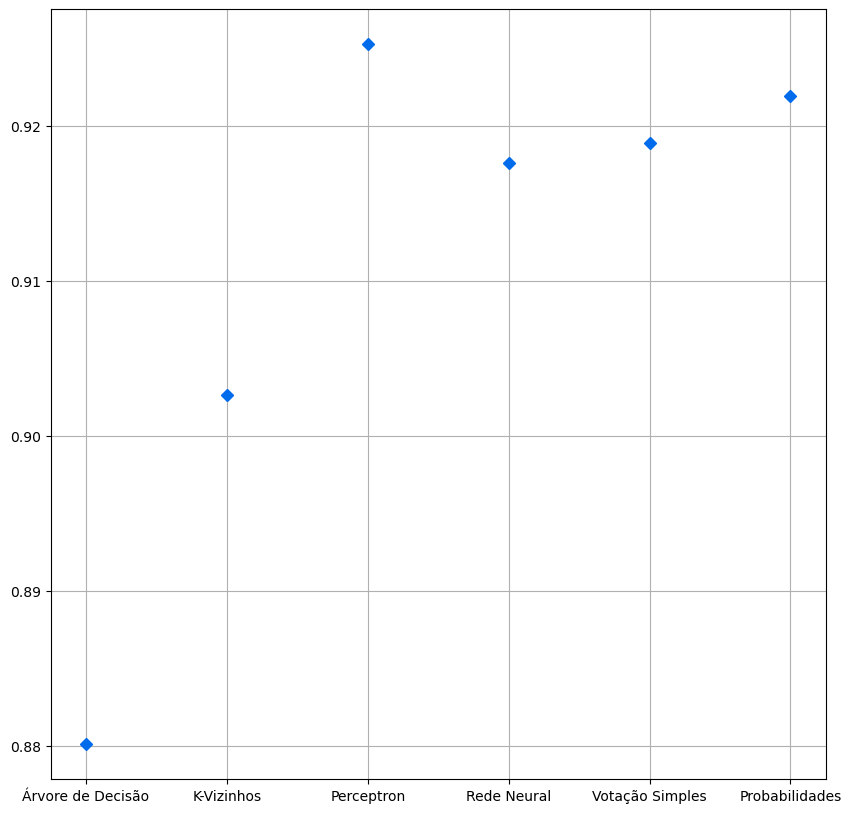

In [183]:
x_labels = ['Árvore de Decisão', 'K-Vizinhos', 'Perceptron', 'Rede Neural', 'Votação Simples', 'Probabilidades']
plt.figure(figsize=(10,10))
plt.plot(x_labels, scores_list, 'D', color='#006BEB')
plt.grid()

## Voting Classifier

Para comparação foi testado também o algoritmo `VotingClassifier` da biblioteca `sklearn`, no modo `voting='soft'`. Nesse modo, a votação para classe selecionada é realizada através das probabilidades ou scores. O resultado obtido foi também de cerca de 92%, sendo muito semelhante aos outros classificadores previamente implementados.

In [181]:
comite = VotingClassifier(estimators=[('dtc', dtc), ('knc', knc), ('mlp', mlp)], voting='soft')

comite.fit(X_train, y_train)
comite_pred = comite.predict(X_test)

/home/fonta42/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9235697562172049

In [186]:
c_matrix_comite = confusion_matrix(y_test, comite_pred)
print(classification_report(comite_pred, y_test))

balanced_accuracy_score(y_test, comite_pred)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     15489
           1       0.88      0.96      0.92     10487

    accuracy                           0.93     25976
   macro avg       0.92      0.93      0.93     25976
weighted avg       0.93      0.93      0.93     25976



0.9235697562172049

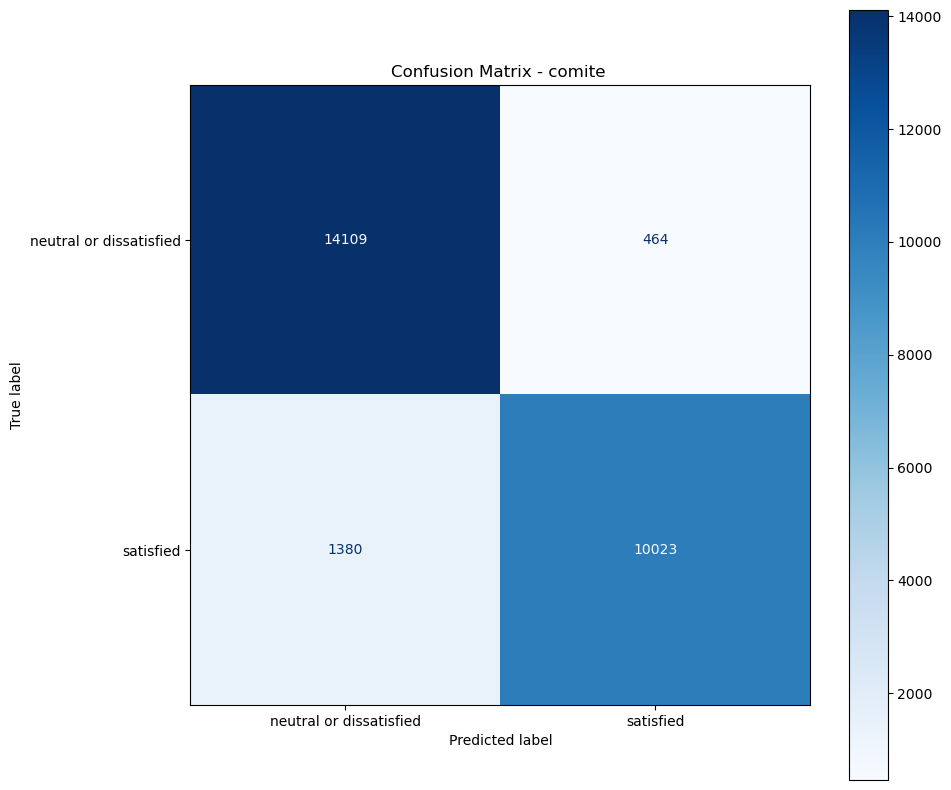

In [182]:
plot_cf(c_matrix_comite, classifier='comite')

### Análise dos resultados

A técnica de comitê utilizando os classificadores Arvore de Decisão, KNN e MLP mostrou um comportamento similar ao da soma de probabilidades.

### Conclusões Finais

Finalmente, é possível concluir observando o comportamento dos algoritmos de combinação através da propagação da leve predominância nos falsos negativos apresentada por todos os modelos de classificação, exceto a Rede Neural Artifical. A implementação da combinação obteve resultados superiores aos classificadores K-Vizinhos e Árvore de Decisão e atingiu resultados muito próximos aos do Perceptron e da Rede Neural.

Dessa forma, pode-se concluir que caso necessário atingir a maior acurácia possível para esse dataset recomenda-se a implementação do Perceptron Multicamadas, no entanto a implementação de outros métodos de classificação aliados à algoritmos de combinação também obtém valores satisfatórios adicionando uma variância aos resultados.